::: {.content-visible when-meta="verbose"}
# Initialization
:::

In [ ]:
# General R and plotting 
library(tidyverse)
library(ggplot2)
library(scales)
library(patchwork)
library(cowplot)
library(gridExtra)
library(ggrepel)
library(stringr)
library(VennDiagram)
library(pheatmap)
library(viridis)
library(here)
library(knitr)

# Single Cell Analysis Packages
library(Seurat)
library(scRepertoire)
library(immunarch)
library(circlize)
library(scCustomize)
library(SingleR)
library(celldex)
library(UCell)
# library(scplotter)

# DEG, pathway enrichment and visualization packages
library(DESeq2)
library(clusterProfiler)
library(DOSE)
library(pathview)
library(org.Mm.eg.db)
library(scRepertoire)
library(enrichplot)
library(msigdbr)
library(gprofiler2)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: 

In [ ]:
#| results: hide
i_am('scripts/TCR_analysis.ipynb')
here()
path <- here()
results_path <- here('results/')
dir.create(results_path)
figures_path <- here('results/figures/')
dir.create(figures_path)
data_path <- here('data/')
dir.create(data_path)

diverging_palette <- hcl.colors(n = 20,'Purple-Green',rev = T)
sequential_palette_dotplot <- hcl.colors(n = 20,'YlGn',rev = T)
sequential_palette <- hcl.colors(n = 20,'Mako',rev = T)

color_palette <- c( 'Type 17 DNs'= '#ccb951',
 'Type 1 DNs'= '#ee8f6b',
 'Activated Type 1 DNs'= '#7bcc7e',
 'Cycling'= '#e58ed4',
 'Other'= '#93a2ee',
 'ISG'= '#44d0d6')

here() starts at /Users/eduardansaldo/Scripps Research Dropbox/Eduard Ansaldo Gine/Constantinides lab/Experiments/Eduard/202507_lung_B2m_Nikhita



[1] "/Users/eduardansaldo/Scripps Research Dropbox/Eduard Ansaldo Gine/Constantinides lab/Experiments/Eduard/202507_lung_B2m_Nikhita"

Warning message in dir.create(results_path):
“'/Users/eduardansaldo/Scripps Research Dropbox/Eduard Ansaldo Gine/Constantinides lab/Experiments/Eduard/202507_lung_B2m_Nikhita/results' already exists”
Warning message in dir.create(figures_path):
“'/Users/eduardansaldo/Scripps Research Dropbox/Eduard Ansaldo Gine/Constantinides lab/Experiments/Eduard/202507_lung_B2m_Nikhita/results/figures' already exists”
Warning message in dir.create(data_path):
“'/Users/eduardansaldo/Scripps Research Dropbox/Eduard Ansaldo Gine/Constantinides lab/Experiments/Eduard/202507_lung_B2m_Nikhita/data' already exists”


:::{.content-visible when-meta='processing'}
# Processing
:::

:::{.content-visible when-meta='verbose'}
## Read in data
:::

In [ ]:
seurat <- readRDS(here('data', 'dnV4clustered.rds'))


contigs <- read.csv(here('data', 'filtered_contig_annotations.csv'))

#Demultiplexing VDJ libraries
contig_list <- createHTOContigList(contigs, seurat, group.by = "condition")
# names(contig_list)

contig_list <- contig_list[c(levels(seurat$condition))]


[1] "CrePosInf"   "CreNegInf"   "CrePosUninf" "CreNegUninf"

In [ ]:
# Combining the Contigs
combined <- combineTCR(contig_list, removeNA = TRUE, samples=c(levels(seurat$condition)), filterMulti = TRUE)

# # #Adding groups as variables
# combined <- addVariable(combined, variable.name='Groups', variables=c(
#                                                 'SPF-iso',
#                                                 'SPF-iso',
#                                                 'SPF-iso',
#                                                 'SPF-iso',
#                                                 'SPF-aCD3',
#                                                 'SPF-aCD3',
#                                                 'SPF-aCD3',
#                                                 'GF-iso',
#                                                 'GF-iso',
#                                                 'GF-iso',
#                                                 'GF-iso',
#                                                 'GF-aCD3',
#                                                 'GF-aCD3',
#                                                 'GF-aCD3',
#                                                 'GF-aCD3')).          

# #Adding Samples as variables
combined <- addVariable(combined, variable.name='condition', variables=c(levels(seurat$condition)))                                    

:::{.content-visible when-meta='verbose'}
## Integrating data with seurat object
:::

In [ ]:
## Integrating analysis with the UMAP
### Combining with the seurat object

# seurat <- RenameCells(seurat, new.names=seurat$cell_barcodes)
# colnames(seurat@meta.data)
cell_names <- Cells(seurat)

groups_merge <- pull(seurat@meta.data, condition)
# head(cell_names)
# head(combined[[1]]$barcode)

#Changing barcodes on the seurat object for the merge with VDJ data
new_cell_names <- paste(groups_merge, cell_names, sep='_')
seurat$barcode <- cell_names
seurat <- RenameCells(seurat, new.names=new_cell_names)

# #Combining VDJ and Seurat Object
#seurat <- combineExpression(combined, seurat, proportion = TRUE, cloneCall='aa', group.by='', cloneSize = c(Rare = 0.5e-04, Small = 0.0005, Medium = 0.005, Large = 0.05, Hyperexpanded = 1))
seurat <- combineExpression(combined, seurat, proportion = TRUE, cloneCall='aa', group.by='condition', chain = 'both')
# table(seurat$cloneSize)


:::{.content-visible when-meta='verbose'}
## Create Groups
:::

In [ ]:
seurat@meta.data <- seurat@meta.data |>
    mutate(Groups = factor(condition, levels = c('CreNegUninf', 'CrePosUninf', 'CreNegInf', 'CrePosInf')))

:::{.content-visible when-meta='processing'}
## Re Clustering without VDJ information
:::

:::{.content-visible when-meta='processing'}
In the presence of clonal expansions, sometimes the expanded VDJ genes can drive clustering themselves come without representing any underlying differences in the gene expression program. Because of this, I am reclustering the dataset but preventing the VDJ genes from driving clustering.
:::

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  Ccl5, Ms4a4b, Sell, Gramd3, Klf2, Itga4, Cd7, Gimap7, Sidt1, Fcer1g 
	   Aff3, Klra7, Lef1, Ikzf2, Xcl1, Cd160, Cmah, Smc4, Klrc1, Klhdc2 
	   Klra6, Eomes, Slamf7, Ifngas1, Fgf13, Dnajb1, Gm8369, Ighm, Actn1, Klrb1c 
Negative:  Tmem176b, Pxdc1, Tmem176a, Il23r, Il1r1, Ramp1, Igf1r, Ramp3, Ckb, Lmo4 
	   Capg, S100a4, Maf, Ltb4r1, Ly6g5b, Rorc, Rora, Serpinb1a, Cxcr6, Sdc1 
	   Blk, Il17re, Ccr2, Il2ra, Coro2b, Cpm, Ifngr2, Nrip1, Mtss1, Smox 
PC_ 2 
Positive:  Sell, Lef1, Aff3, Sidt1, Emb, Gramd3, Ltb, Fgf13, Ldlrad4, Ctla2a 
	   Socs3, Cmah, Ighm, Gm8369, Actn1, Xcl1, Zeb1, Lyst, Smyd3, Bcl2l11 
	   Rgs10, B2m, Neurl3, Ifngas1, Abtb3, Rps12, Dnajb1, Ccr7, Cd55, Gm20186 
Negative:  Pclaf, Birc5, Mki67, Spc24, Tpx2, Cdca3, Cdca8, Kif11, Stmn1, Cks1b 
	   H1f5, Esco2, Aurkb, Nuf2, Ckap2l, Hmmr, Ncapg, Cenpe, Shcbp1, Rrm2 
	   Cenpf, Asf1b, Neil3, Tk1, H3c3, Prc1, Fbxo5, Ncapg2, Rad51ap1, Uhr

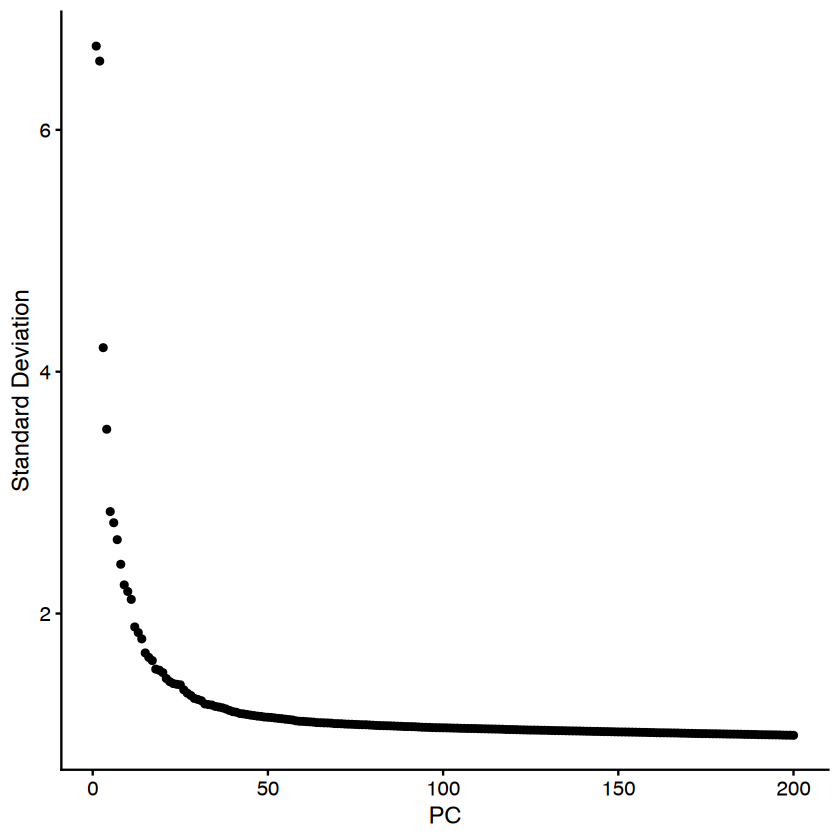

In [ ]:
#| fig-cap: 'Elbow plot showing the percentage of variability represented by by each PC to select number of dimensions '
# Find and scale variable features
DefaultAssay(seurat) <- "RNA"
seurat <- FindVariableFeatures(seurat, selection.method = "vst", nfeatures = 2000) |> quietVDJgenes()

top25  <- head(VariableFeatures(seurat), 25)

# plot1 <- VariableFeaturePlot(seurat)
# plot2 <- LabelPoints(plot = plot1, points=top25, repel=TRUE)
# plot1+plot2

#Scaling the Data
all.genes <- rownames(seurat)
seurat <- ScaleData(seurat, features=all.genes)

#Dimensionality reduction
seurat <- RunPCA(seurat, features = VariableFeatures(object=seurat), npcs=200)

#Determining dimensionality of the dataset
ElbowPlot(seurat, ndims = 200)



:::{.content-visible when-meta='processing'}
Dimensions
:::

In [ ]:
# Describe number of dimensions

dimensions  <- 45
dimensions


In [ ]:
#| results: hide
resolutions <- c(0.25, 0.5, 1, 1.25, 1.5, 1.75, 2, 3, 4, 5)
seurat <- FindNeighbors(seurat, dims = 1:dimensions)
seurat <- FindClusters(seurat, resolution = resolutions)
seurat <- RunUMAP(seurat, dims=1:dimensions )

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 27252
Number of edges: 894778

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9132
Number of communities: 10
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 27252
Number of edges: 894778

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8764
Number of communities: 17
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 27252
Number of edges: 894778

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8282
Number of communities: 24
Elapsed time: 2 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 27252
Number of edges: 894778

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8116
Number of communities: 26
Elapsed time: 2 seconds
Modularity O

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:41:22 UMAP embedding parameters a = 0.9922 b = 1.112

14:41:22 Read 27252 rows and found 45 numeric columns

14:41:22 Using Annoy for neighbor search, n_neighbors = 30

14:41:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:41:23 Writing NN index file to temp file /var/folders/mz/_0gb0g1x5mnctzqv_vstmj600000gn/T//Rtmpp7EGHV/file25383691ee91

14:41:23 Searching Annoy index using 1 thread, search_k = 3000

14:41:27 Annoy recall = 100%

14:41:28 Commencing smooth kNN distance calibra

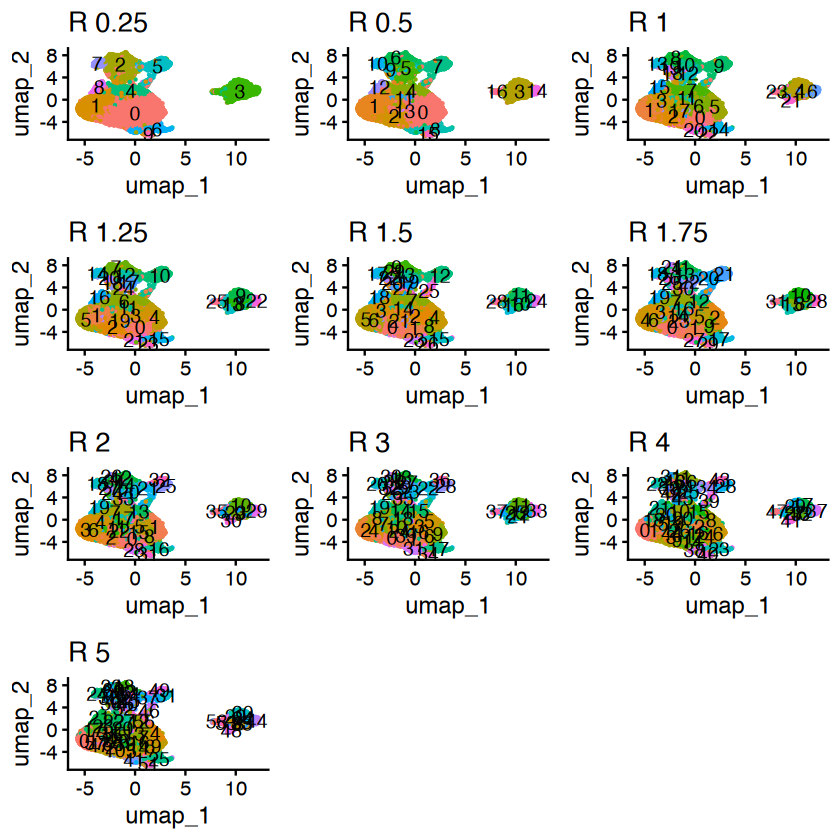

In [ ]:
#| fig-cap: 'UMAP plots showing the clustering results at different resolutions'
#| fig.width: 8
#| fig.height: 8

p <- list()
i <- 1
for (resolution in resolutions ) {
    Idents(seurat) <- paste0('RNA_snn_res.', resolution) 
    p2 <- DimPlot(seurat, reduction = "umap", label = TRUE) + ggtitle(paste0('R ', resolution)) + theme(legend.position = "none")    
    p[[i]] <- p2
    i <- i+1
}

plot <- grid.arrange(grobs = p)
# ggsave('initial_clustering_results_by_resolution.pdf', path = here('result/figures'), plot = plot)


:::{.content-visible when-meta='processing'}
Chosen resolution
:::

In [ ]:
resolution <- 0.25
resolution


[1] 0.25

# Analysis

In [ ]:
seurat <- readRDS(here('data', '20240730_seurat_EA.rds'))

## Clustering Results

Saving 6.67 x 6.67 in image


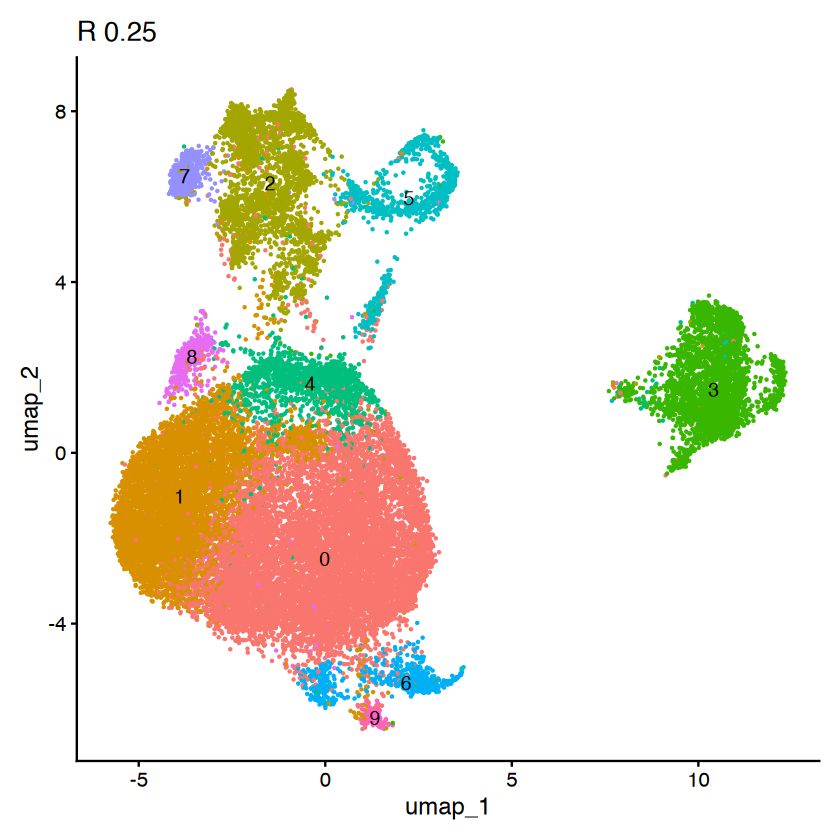

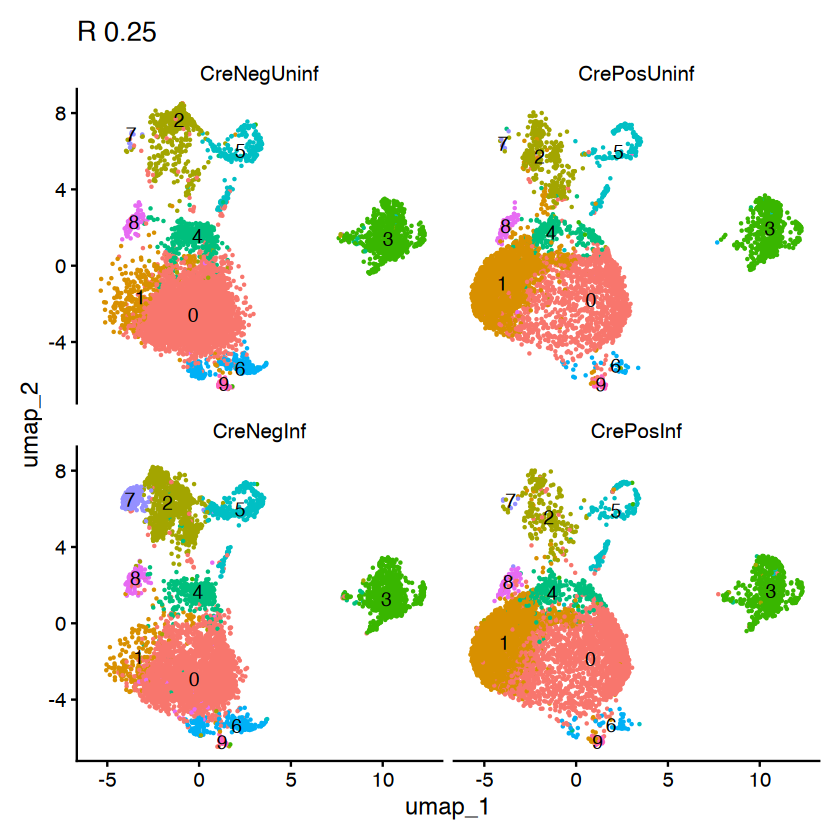

In [ ]:
Idents(seurat) <- paste0('RNA_snn_res.', resolution)
seurat[['seurat_clusters']]<- Idents(seurat)
DimPlot(seurat, reduction = "umap", label = TRUE) + ggtitle(paste0('R ', resolution)) + theme(legend.position = "none")
ggsave(paste0('UMAP_clusters_R_', resolution, '.pdf'), path = figures_path)
DimPlot(seurat, reduction = "umap", label = TRUE, split.by = 'Groups', ncol = 2) + ggtitle(paste0('R ', resolution)) + theme(legend.position = "none")
ggsave(paste0('UMAP_clusters_by_group_R_', resolution, '.pdf'), path = figures_path, width = 12, height = 5)

## Cluster Proportions

Saving 6.67 x 6.67 in image


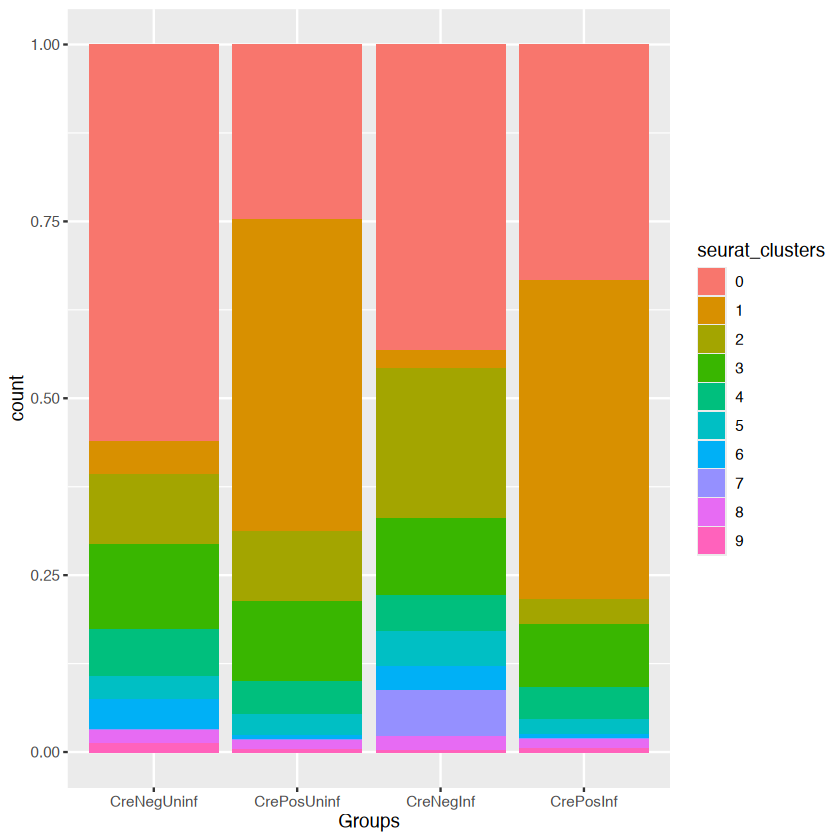

Saving 6.67 x 6.67 in image


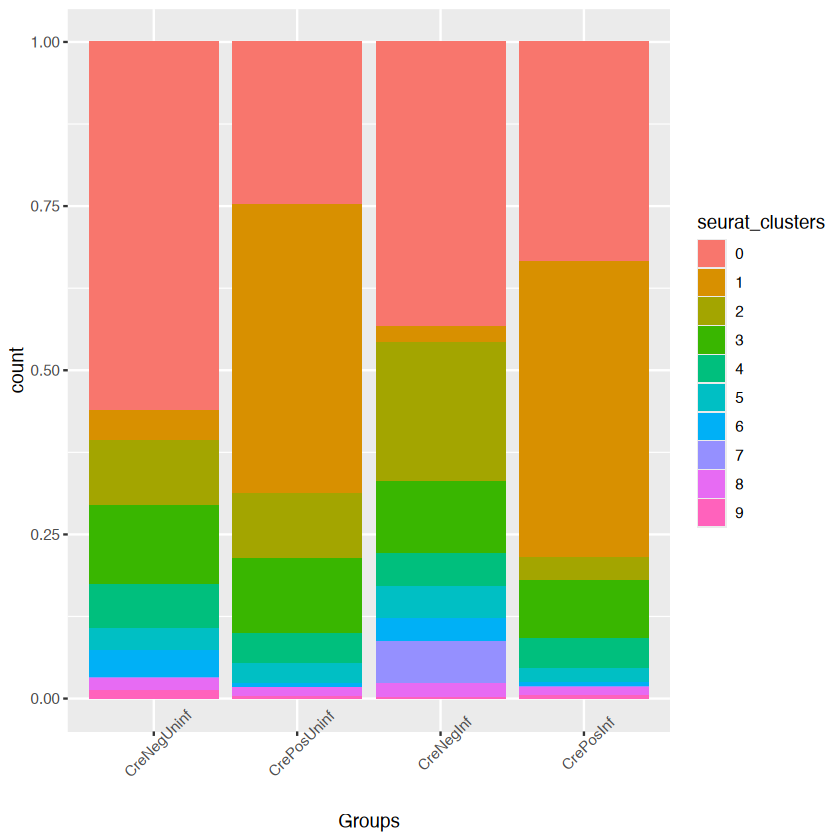

In [ ]:
#path <- './'
# Extracting cell counts for bar graphs
cell_counts <- FetchData(seurat,vars=c('seurat_clusters', "Groups")) 
cell_counts <- arrange(cell_counts, Groups)


counts <- cell_counts %>% add_count(Groups, name='total_cell_count_by_sample') #%>%  ungroup() %>% arrange( seurat_clusters , desc(hash.ID) ) #%>% arrange('seurat_clusters')

counts <- counts %>% 
    dplyr::count(seurat_clusters, Groups, total_cell_count_by_sample,name='cluster_count')  |> 
        mutate(frequency_within_sample=cluster_count*100/total_cell_count_by_sample)  |> 
        mutate(Groups = as.character(Groups)) |> 

        arrange( Groups, desc(Groups)) #%>% arrange('seurat_clusters')

new_counts <- counts |> 
    arrange(Groups) |>     
    pivot_wider(id_cols = seurat_clusters, names_from = 'Groups', values_from = frequency_within_sample)
    
write.csv(new_counts,file=paste0(results_path,"number of cells per cluster per condition.csv"),row.names=F)

colors <- c('deeppink', 'deeppink3', 'hotpink', 'hotpink4', 'cadetblue', 'cadetblue2', 'deepskyblue', 'deepskyblue4')
# Barplot of proportion of cells in each cluster by sample
ggplot(seurat@meta.data) +
    geom_bar(aes(x=Groups, fill=seurat_clusters), position=position_fill()) 
ggsave(paste0(figures_path, 'cells_per_cluster_per_group.pdf'))

# # Barplot of proportion of cells in each cluster by sample
# ggplot(seurat@meta.data) +
#     geom_bar(aes(x=Groups, fill=seurat_clusters), position=position_fill())+ theme(axis.text.x = element_text(angle = 45, vjust = 1))
# ggsave(paste0(figures_path, 'cells_per_cluster_per_sample.pdf'))
    

## Top gene per cluster

Calculating cluster 0



Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Warning message in left_join(seurat.markers, y = unique(annotations[, c("gene_name", :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1078 of `x` matches multiple rows in `y`.
ℹ Row 2819 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


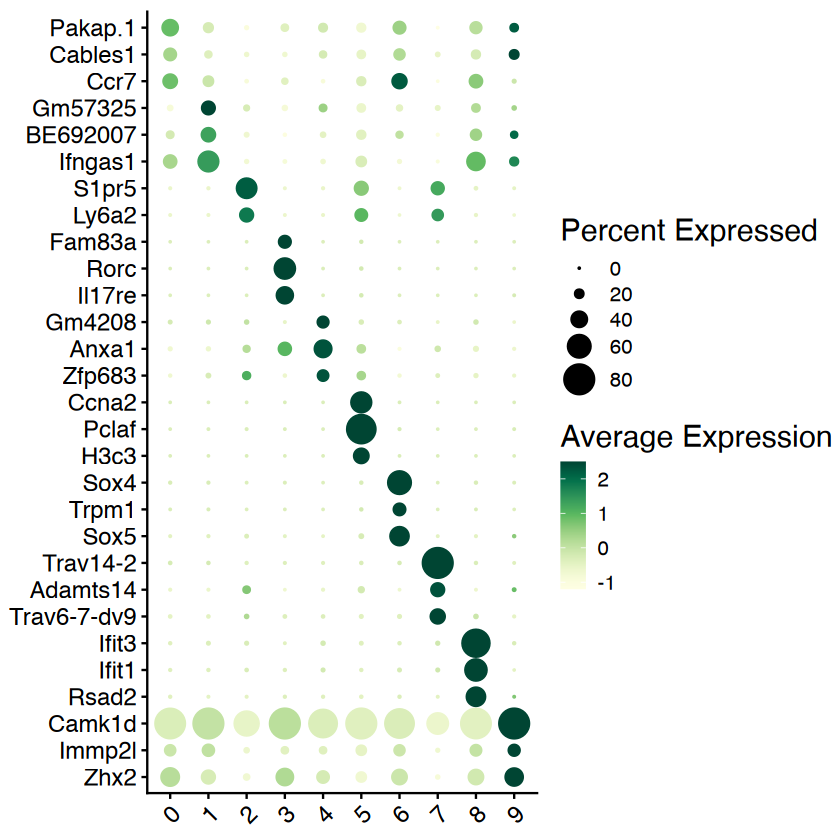

In [ ]:
#| fig.height: 9
#| fig.width: 8
object_annotations <- 'global'
 
Idents(seurat) <- 'seurat_clusters'

seurat.markers <- FindAllMarkers(seurat, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

# saveRDS(seurat.markers, file = 'seurat.markers.rds')



#Add gene annotations:
annotations <- read.csv(here("scripts/annotations.csv"))
seurat.markers <- seurat.markers |>
                left_join(y= unique(annotations[,c('gene_name', 'description')]),
                    by = c('gene' = 'gene_name'))

                    

#Top10 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 10) -> top10

#Top25 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 25) -> top25

#Top100 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 100) -> top100

#Top3 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 3) -> top3

write.table(top100,file=paste0(results_path,'top100', '_',object_annotations, ".tsv"), sep="\t",row.names = FALSE)
# write.table(top25,file=paste0(path,'top25',object_annotations, ".tsv"), sep="\t",row.names = FALSE)
write.table(top10,file=paste0(results_path,'top10', '_',object_annotations, ".tsv"), sep="\t",row.names = FALSE)


# # #Top5 markers
# seurat.markers %>%
#     group_by(cluster) %>%
#     slice_head(n = 5) -> top5
# DoHeatmap(seurat, features = top5$gene, size = 1) + NoLegend() & theme(text=element_text(size=6))
# ggsave(paste0("Heatmap_Top5_per_cluster", object_annotations, ".pdf"), path = path)

# #Top10 markers
# seurat.markers %>%
#      group_by(cluster) %>%
#      slice_head(n = 10) -> top10
#  DoHeatmap(seurat, features = top10$gene, size = 1) + NoLegend() & theme(text=element_text(size=4)) 
#  ggsave(paste0("Heatmap_Top10_per_cluster", object_annotations, ".pdf"), path = path)

gene_list_plot <- top3 |> pull(gene)

gene_list_plot <- gene_list_plot |> unique() |> rev()
DotPlot_scCustom(seurat,
                features = gene_list_plot,
                colors_use=sequential_palette_dotplot,
                flip_axes = T,
                dot.scale = 8,
                dot.min = 0,
                scale.min = 0,
                scale.max = 80,
                x_lab_rotate = T,
                y_lab_rotate = F) +
    theme(axis.text.x = element_text(size = 14),
         axis.text.y = element_text(size = 14),
         legend.title = element_text(size = 18))
ggsave(paste0(figures_path, 'DotPlot_Top3_per_cluster.pdf'), width = 10, height = 8)

:::{.content-visible when-meta='verbose'}
### Automatic cell type annotations
:::

In [ ]:
#| include: false
local_path <- paste0(results_path,object_annotations,'cell_type_annotations')
unlink(local_path,recursive = T)
dir.create(local_path)


:::{.content-visible when-meta='verbose'}
Annotation per cluster
:::

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in c

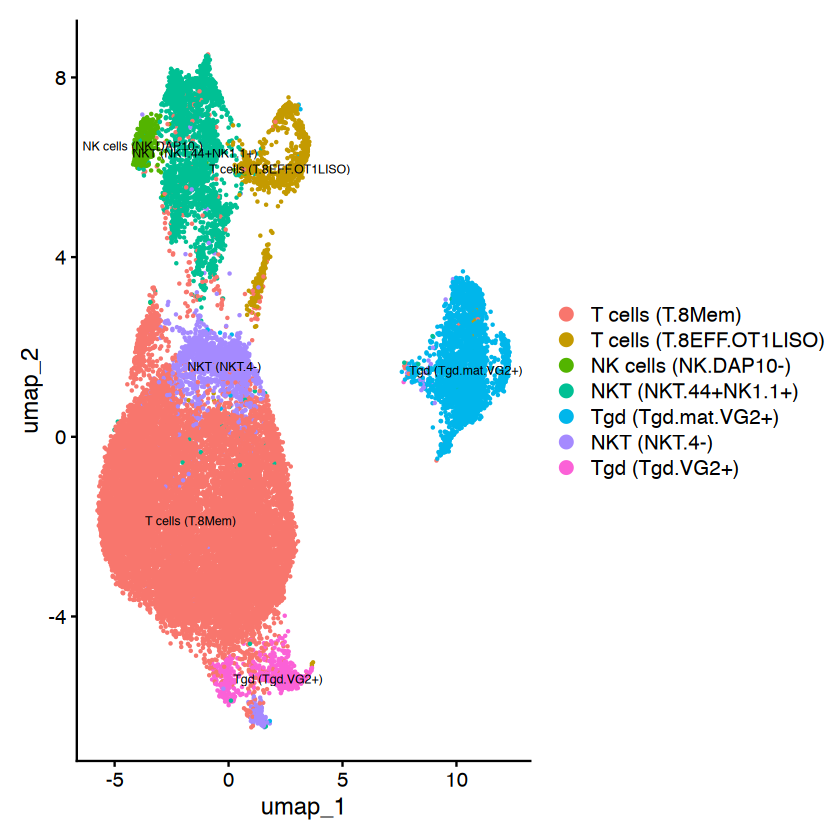

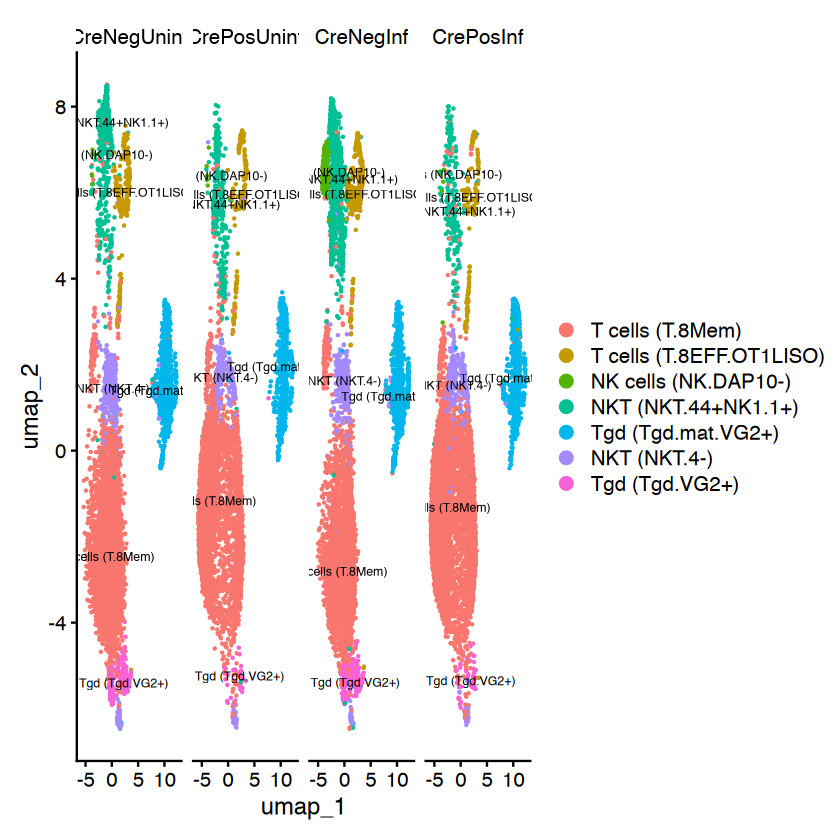

In [ ]:
#| include: false
#| fig-cap: 'Automatic cell type annotations, using SingleR with ImmGen dataset. These are often incorrect, just serve as a starting point'

immgen <- ImmGenData(ensembl = FALSE)
predictions_cluster <- SingleR(test = as.SingleCellExperiment(seurat), assay.type.test = , ref = immgen, labels = immgen$label.fine, cluster = seurat$seurat_clusters)

row.names <- rownames(predictions_cluster)

predictions_cluster <- predictions_cluster |>
    as_tibble() |> 
    dplyr::select(c('labels')) 

predictions_cluster$cluster <- row.names

#predictions_cluster <- predictions_cluster |> rename('labels_per_cluster' = 'labels')

annotations <- seurat@meta.data |>
    left_join(predictions_cluster, by = join_by('seurat_clusters' == 'cluster')) |>
    pull(labels)

seurat$labels_per_cluster <- annotations

Idents(seurat) <- 'labels_per_cluster'
DimPlot(seurat, label = T, label.size = 2.5)
ggsave(paste0('UMAP_cluster_SingleR_annotations','.pdf'), path = local_path, width = 8, height = 5)
DimPlot(seurat, label = T, label.size = 2.5, split.by = 'Groups')
ggsave(paste0('UMAP_cluster_SingleR_annotations_by_group','.pdf'), path = local_path, width = 13, height = 5)


:::{.content-visible when-meta='verbose'}
Annotations per cell
:::

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in c

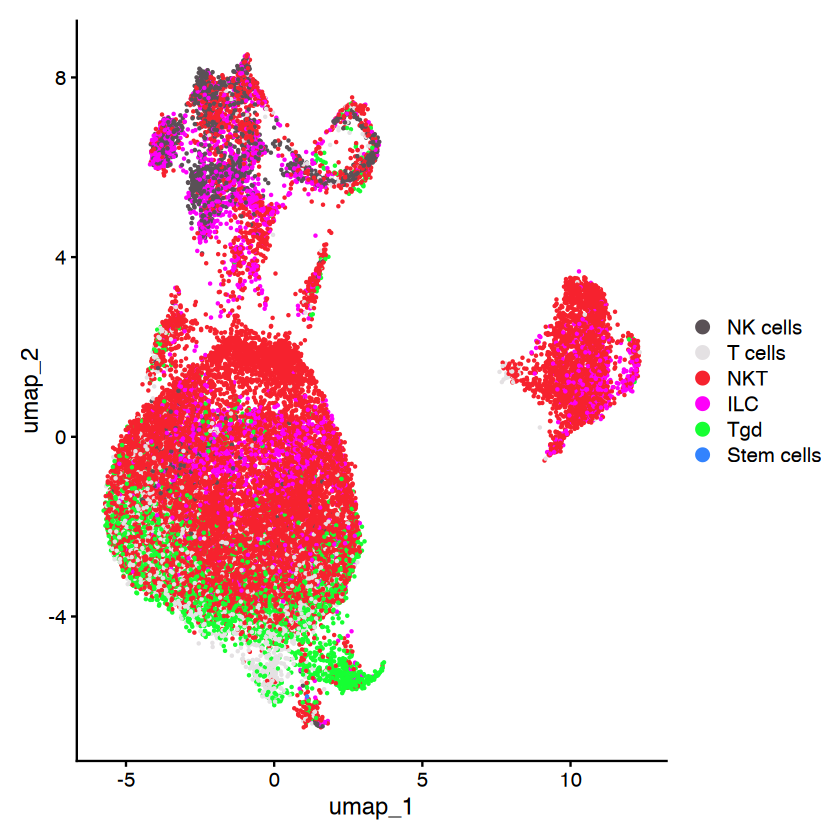

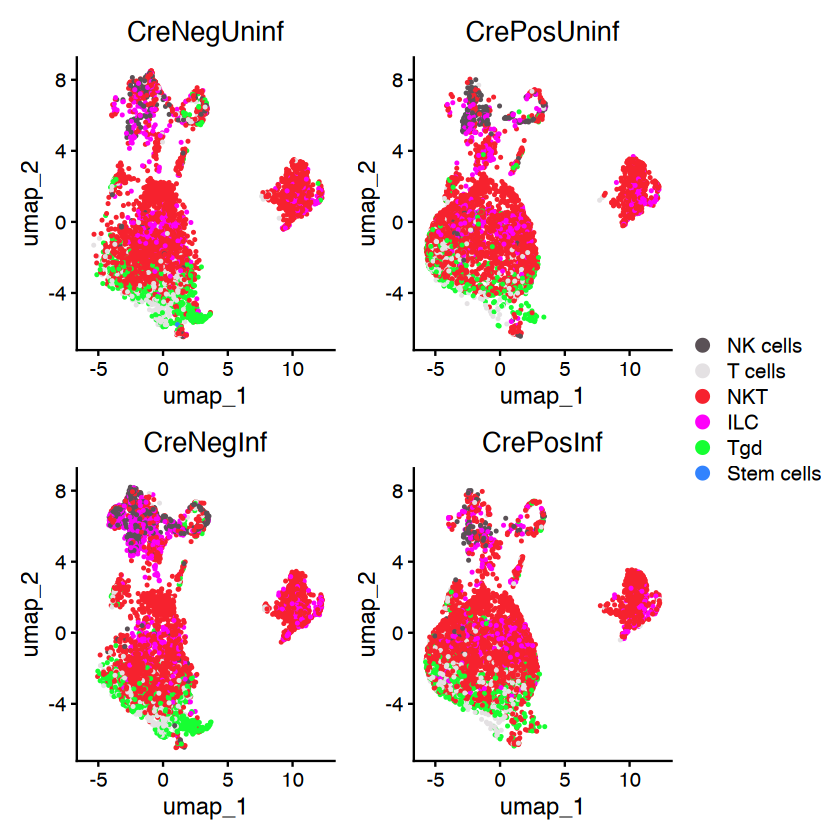

In [ ]:
#| include: false
#| fig-cap: 'Automatic cell type annotations, using SingleR with ImmGen dataset. These are often incorrect, just serve as a starting point'
immgen <- ImmGenData(ensembl = FALSE)
predictions_cell_basis <- SingleR(test = as.SingleCellExperiment(seurat), assay.type.test = 1, ref = immgen, labels = immgen$label.main)

predictions_cell_basis <- predictions_cell_basis |>
    as_tibble() |> 
    dplyr::select(c('labels')) 

predictions_cell_basis <- predictions_cell_basis |> rename('labels_per_cell_coarse' = 'labels')

seurat$labels_per_cell_coarse <- predictions_cell_basis |> pull(labels_per_cell_coarse)
    
Idents(seurat) <- 'labels_per_cell_coarse'
DimPlot_scCustom(seurat, label = F)#+ theme(legend.position = 'none')
ggsave(paste0('UMAP_cell_SingleR_annotations_coarse','.pdf'), path = local_path, width = 5, height = 5)
DimPlot_scCustom(seurat, label = F, split.by = 'Groups')#+ theme(legend.position = 'none')
ggsave(paste0('UMAP_cell_SingleR_annotations_coarse_by_group','.pdf'), path = local_path, width = 13, height = 5)


Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in c

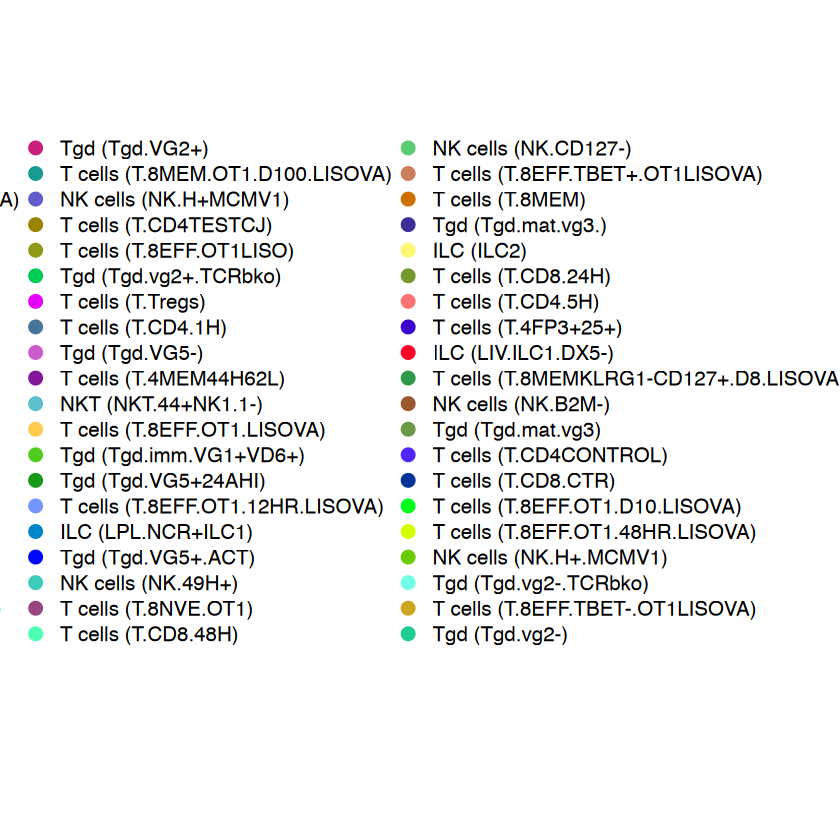

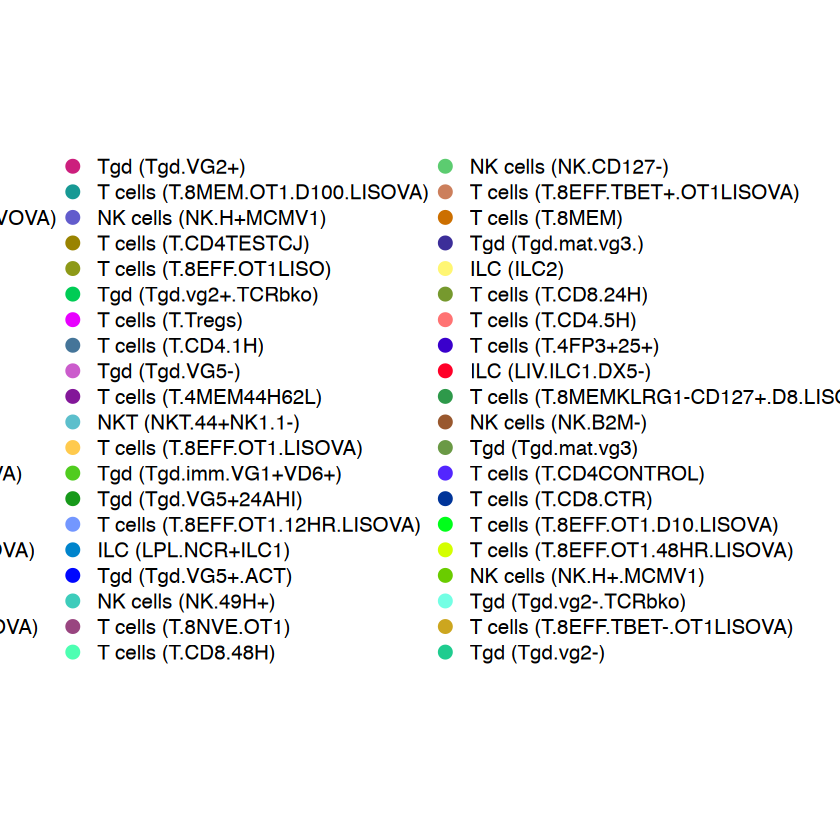

In [ ]:
#| include: false
immgen <- ImmGenData(ensembl = FALSE)
predictions_cell_basis <- SingleR(test = as.SingleCellExperiment(seurat), assay.type.test = 1, ref = immgen, labels = immgen$label.fine)

predictions_cell_basis <- predictions_cell_basis |>
    as_tibble() |> 
    dplyr::select(c('labels')) 

predictions_cell_basis <- predictions_cell_basis |> rename('labels_per_cell_fine' = 'labels')

seurat$labels_per_cell_fine <- predictions_cell_basis |> pull(labels_per_cell_fine)
    
Idents(seurat) <- 'labels_per_cell_fine'
DimPlot_scCustom(seurat, label = F)#+ theme(legend.position = 'none')
ggsave(paste0('UMAP_cell_SingleR_annotations_fine','.pdf'), path =local_path, width = 17, height = 5)
DimPlot_scCustom(seurat, label = F, split.by = 'Groups')#+ theme(legend.position = 'none')
ggsave(paste0('UMAP_cell_SingleR_annotations_fine_by_group','.pdf'), path =local_path, width = 30, height = 5)

:::{.content-visible when-meta='verbose'}
## Save Object
:::

In [ ]:
saveRDS(seurat, file = here('data', '20240730_seurat_EA'))

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’



## Plotting Genes of Interest

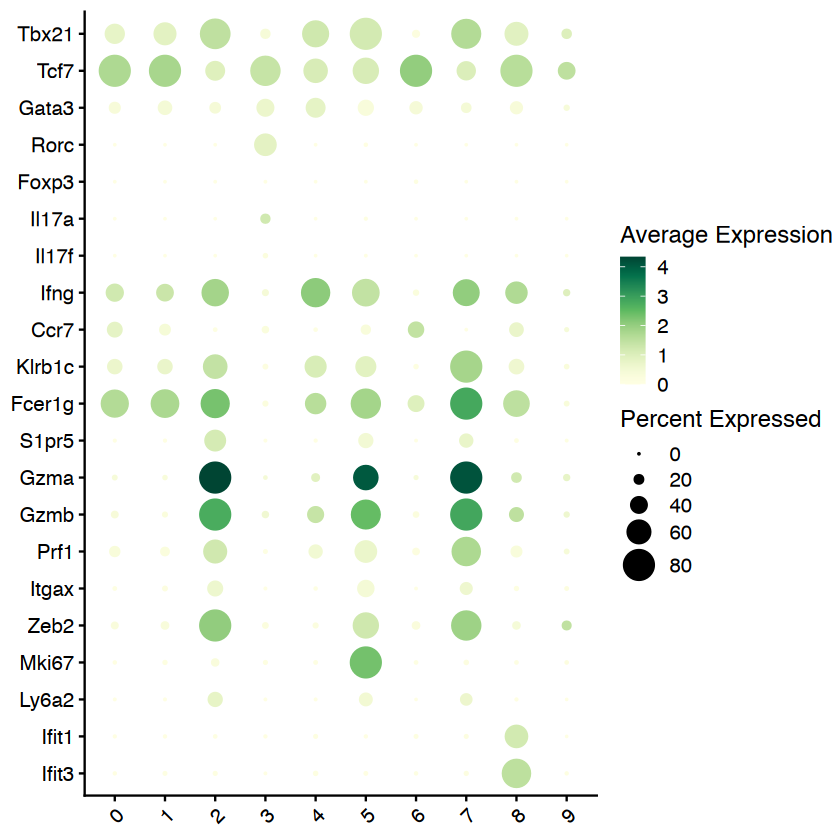

In [ ]:
# DotPlot of selected genes
#| fig-cap: 'DotPlot of selected top genes per cluster, showing expression in each cluster'
#| fig.width: 5
#| fig.height: 11
Idents(seurat) <- 'seurat_clusters'
DotPlot_scCustom(seurat, features = rev(c('Tbx21', 'Tcf7', 'Gata3', 'Rorc', 'Foxp3', 'Il17a', 'Il17f', 'Ifng', 'Ccr7', 'Klrb1c', 'Fcer1g', 'S1pr5', 'Gzma', 'Gzmb', 'Prf1', 'Itgax', 'Zeb2', 'Mki67', 'Ly6a2', 'Ifit1', 'Ifit3')),
                    colors_use = sequential_palette_dotplot,
                    scale = F,
                    flip_axes = T,
                    dot.scale = 8,
                    dot.min = 0,
                    scale.min = 0,
                    scale.max = 80,
                    x_lab_rotate = T,
                    y_lab_rotate = F
                    )

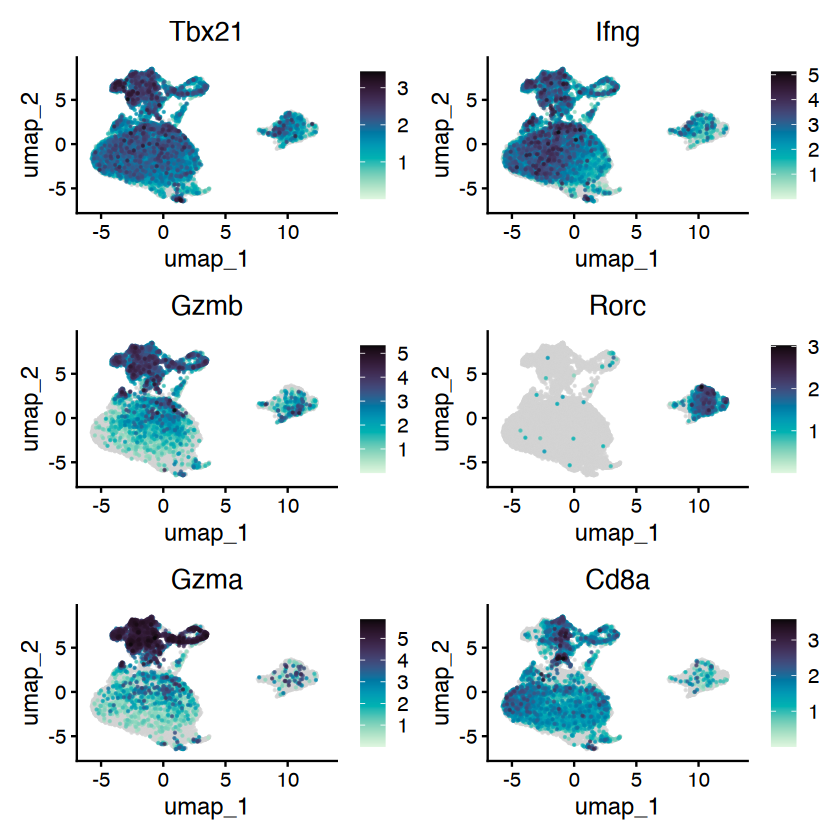

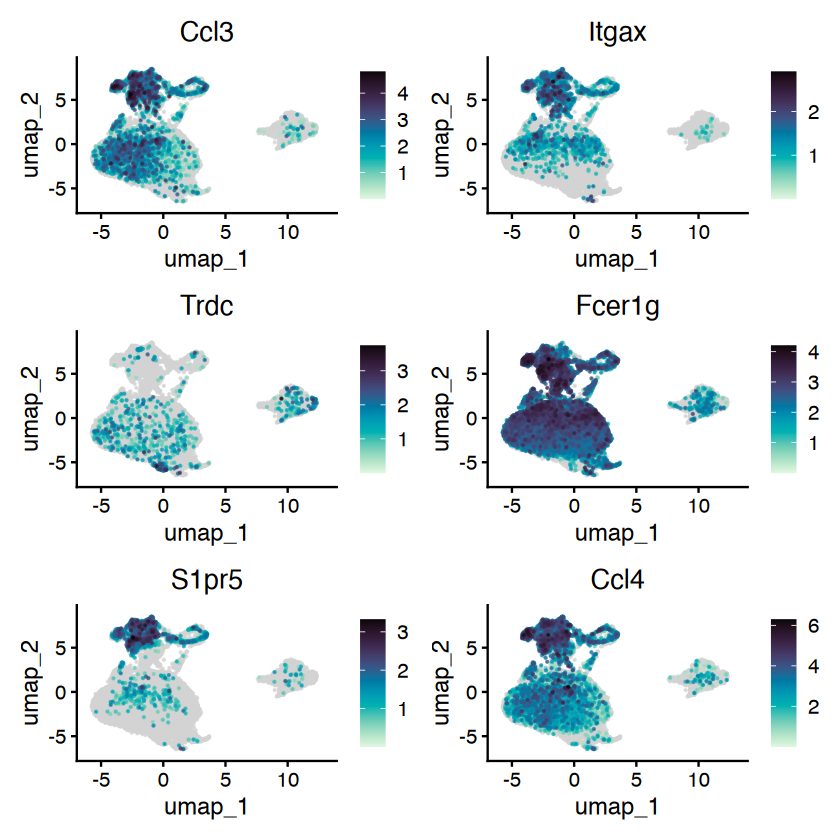

In [ ]:
FeaturePlot_scCustom(seurat, features = c('Tbx21', 'Ifng', 'Gzmb', 'Rorc', 'Gzma', 'Cd8a'),
                    colors_use = sequential_palette, pt.size = 0.01, alpha_exp = 0.7)

FeaturePlot_scCustom(seurat, features = c('Ccl3', 'Itgax', 'Trdc', 'Fcer1g', 'S1pr5', 'Ccl4'),
                    colors_use = sequential_palette, pt.size = 0.01, alpha_exp = 0.7)

### Observations

There seems to be an across the board type 1 program except for cluster 3 (type 17), 6 (possible gd contaminant), and 9 (possible gd contaminant). However, interferon gamma production is focused on cluster 4 and the activated clusters 2, 5, and 7. Overall, It seems that clusters 2, 5 and 7 represent a distinct activated population characterized by cytotoxic function and certain unique patterns of gene expression reminiscent of cells in the intraepithelial or other unique compartment (Cd8a, Fcer1g, Ccl4, Ccl5, Cd11c (Itgax), Cx3cr1, S1pr5, Zeb2), with cluster 5 representing cycling subset within this activated population. Cluster 8 represents a population of interferon-sensing cells.

## Annotating clusters

In [ ]:
Idents(seurat) <- 'seurat_clusters'
seurat <- RenameIdents(seurat
    , '0' = 'Type 1 DNs'  
    , '1' = 'Type 1 DNs'
    , '2' = 'Activated Type 1 DNs'
    , '3' = 'Type 17 DNs'
    , '4' = 'Type 1 DNs'
    , '5' = 'Cycling'
    , '6' = 'Other'
    , '7' = 'Activated Type 1 DNs' 
    , '8' = 'ISG'
    , '9' = 'Other')
seurat[['cell_types']] <- Idents(seurat)

Idents(seurat) <- 'seurat_clusters'
seurat <- RenameIdents(seurat
    , '0' = 'Type 1'  
    , '1' = 'Type 1'
    , '2' = 'Type 1'
    , '3' = 'Type 17'
    , '4' = 'Type 1'
    , '5' = 'Type 1'
    , '6' = 'Type 1'
    , '7' = 'Type 1' 
    , '8' = 'Type 1'
    , '9' = 'Type 1')
seurat[['major_cell_types']] <- Idents(seurat)

In [ ]:
color_palette <- c( 'Type 17 DNs'= '#ccb951',
 'Type 1 DNs'= '#ee8f6b',
 'Activated Type 1 DNs'= '#7bcc7e',
 'Cycling'= '#e58ed4',
 'Other'= '#93a2ee',
 'ISG'= '#44d0d6')

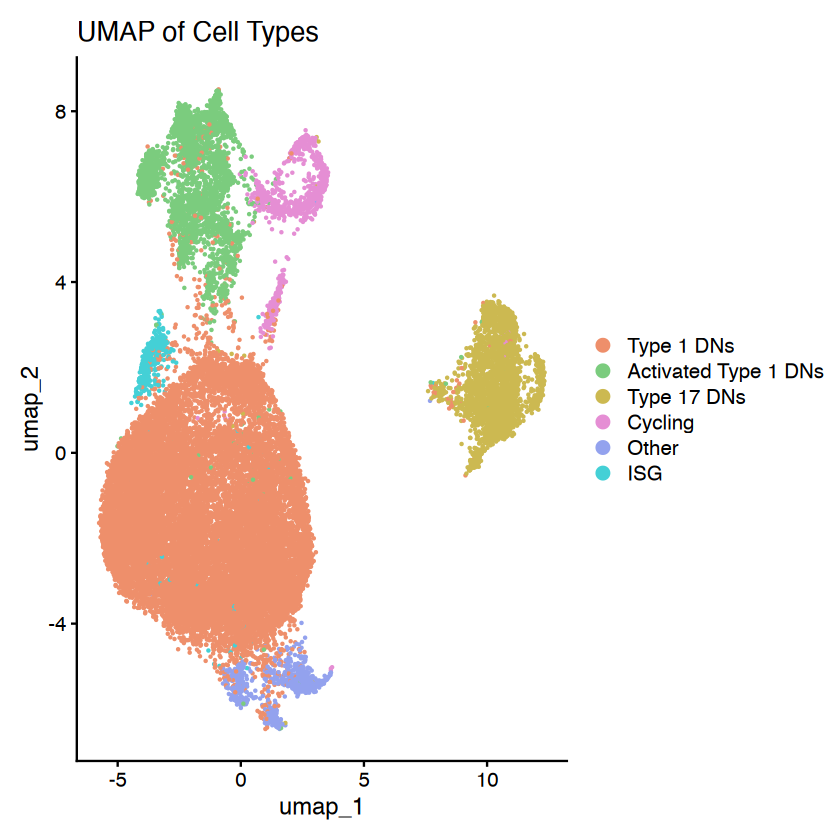

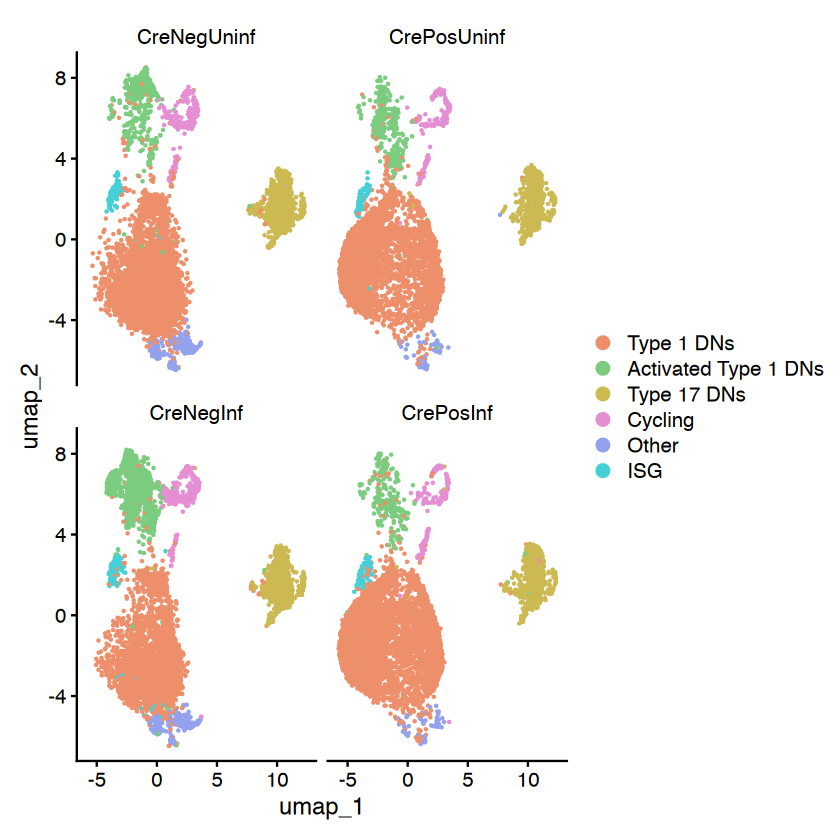

In [ ]:
#| fig.width: 8
#| fig.height: 5

Idents(seurat) <- 'cell_types'
DimPlot(seurat, label=F, ncol = 2, cols = color_palette) +
    labs(title = 'UMAP of Cell Types')
ggsave('UMAP_cell_types.pdf', path = figures_path, width = 7, height = 5)

DimPlot(seurat, label=F, split.by = 'Groups', ncol = 2, cols = color_palette)
ggsave('UMAP_cell_types_by_group.pdf', path = figures_path, width = 8, height = 5)


:::{.content-visible when-meta='verbose'}
## Saving object
:::

In [ ]:
saveRDS(seurat, file=here('data/20240730_seurat_EA.rds'))

## Cell frequency per condition

Saving 6.67 x 6.67 in image


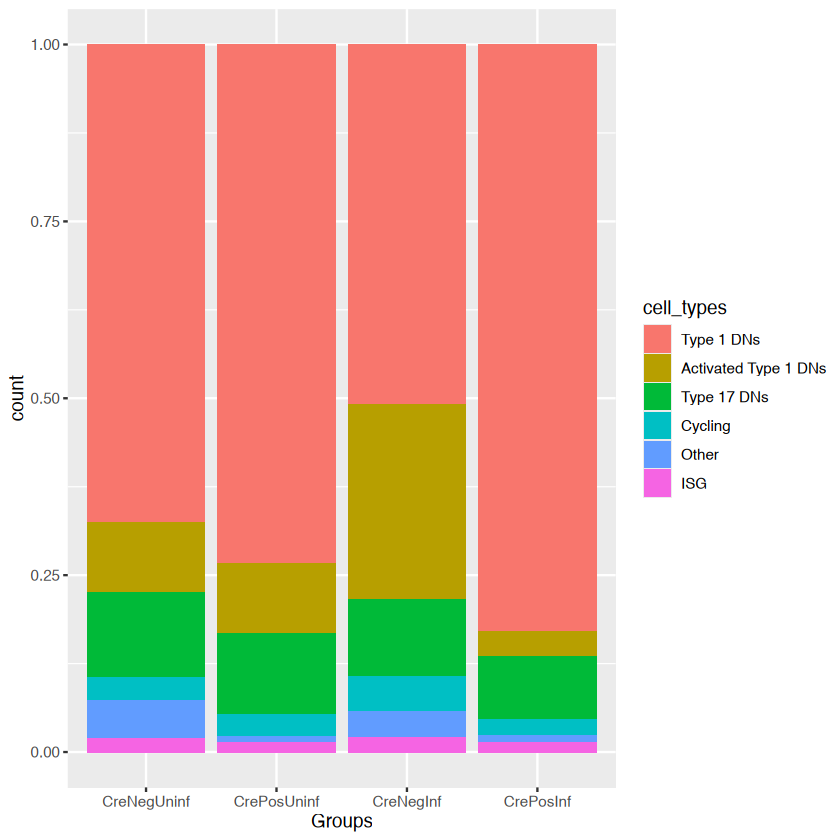

In [ ]:
#path <- './'
# Extracting cell counts for bar graphs
cell_counts <- FetchData(seurat,vars=c('cell_types', "Groups")) 
cell_counts <- arrange(cell_counts, Groups)


counts <- cell_counts %>% add_count(Groups, name='total_cell_count_by_sample') #%>%  ungroup() %>% arrange( cell_types , desc(hash.ID) ) #%>% arrange('cell_types')

counts <- counts %>% 
    dplyr::count(cell_types, Groups, total_cell_count_by_sample,name='cluster_count')  |> 
        mutate(frequency_within_sample=cluster_count*100/total_cell_count_by_sample)  |> 
        mutate(Groups = as.character(Groups)) |> 

        arrange( Groups, desc(Groups)) #%>% arrange('cell_types')

new_counts <- counts |> 
    arrange(Groups) |>     
    pivot_wider(id_cols = cell_types, names_from = 'Groups', values_from = frequency_within_sample)
    
write.csv(new_counts,file=paste0(results_path,"number of cells per cluster per condition.csv"),row.names=F)

colors <- color_palette
# Barplot of proportion of cells in each cluster by sample
ggplot(seurat@meta.data) +
    geom_bar(aes(x=Groups, fill=cell_types), position=position_fill()) 
ggsave(paste0(figures_path, 'cells_per_cluster_per_group.pdf'))

# # Barplot of proportion of cells in each cluster by sample
# ggplot(seurat@meta.data) +
#     geom_bar(aes(x=Groups, fill=cell_types), position=position_fill())+ theme(axis.text.x = element_text(angle = 45, vjust = 1))
# ggsave(paste0(figures_path, 'cells_per_cluster_per_sample.pdf'))
    

# TCR repertoire Analysis

In [ ]:
seurat <- readRDS(here('data', '20240730_seurat_EA.rds'))

## Clonotype Frequency

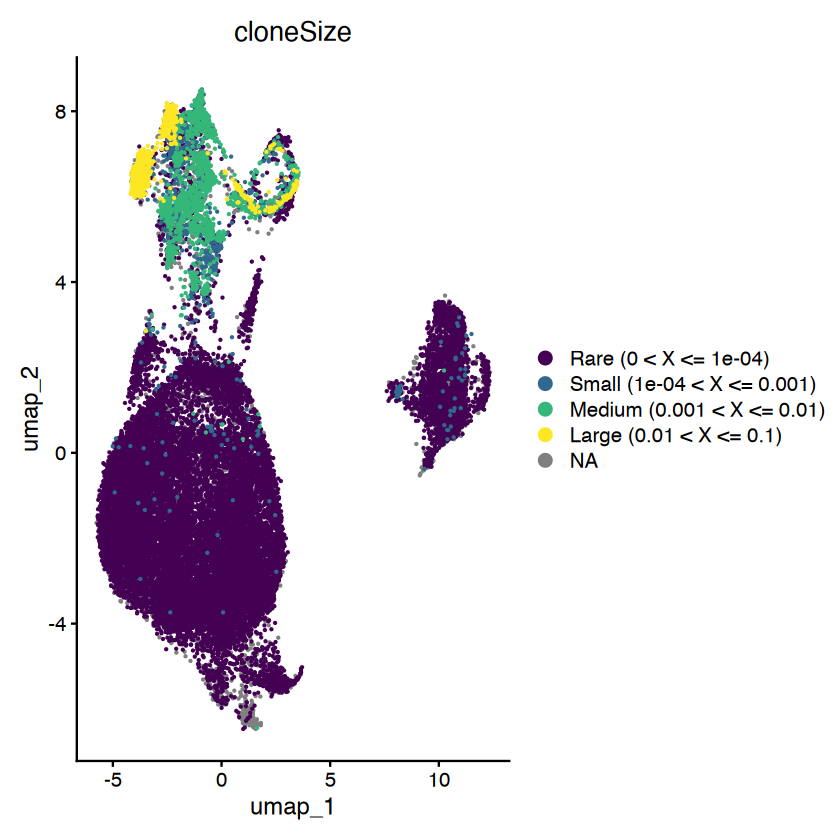

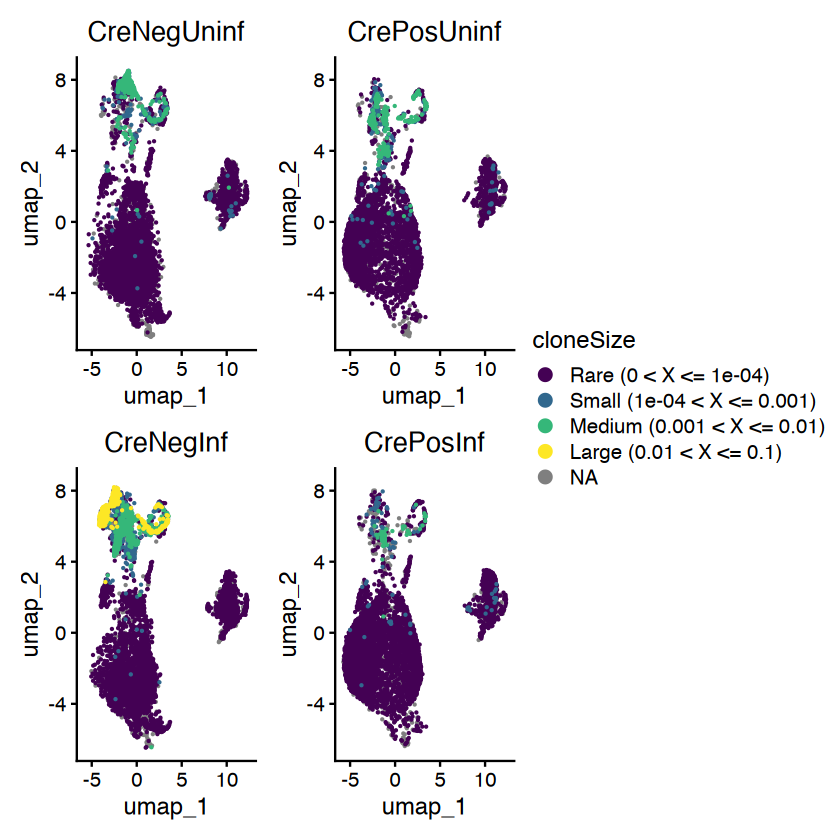

In [ ]:
#| fig.width: 8
#| fig.height: 5

#UMAP clonotype frequency
slot(seurat, "meta.data")$cloneSize <- factor(slot(seurat, "meta.data")$cloneSize, 
                levels = c(
                            "Rare (0 < X <= 1e-04)",
                           "Small (1e-04 < X <= 0.001)",
                            'Medium (0.001 < X <= 0.01)', 
                            'Large (0.01 < X <= 0.1)',
                            # 'Hyperexpanded (0.1 < X <= 1)',
                                                        NA)) 
DimPlot_scCustom(seurat, group.by = "cloneSize", pt.size = 0.01, order=T, colors_use = viridis(4)) 
ggsave(filename = 'UMAP_VDJ_clone_frequencies.pdf', path = figures_path, width = 8, height = 5)
DimPlot_scCustom(seurat, group.by = "cloneSize", pt.size = 0.01, order=T, colors_use = viridis(4), split.by = 'condition')
ggsave(filename = 'UMAP_VDJ_clone_frequencies_by_group.pdf', path = figures_path, width = 16, height = 5)
    
  

:::{.content-visible when-meta='verbose'}
## Parsing alpha and beta gene usage
:::

In [ ]:
#| fig.width: 8
#| fig.height: 5

# Checking for full TCR sequences
seurat@meta.data <- seurat@meta.data |>
    mutate(TCR_exists = ifelse(is.na(CTaa), 'NO', 'YES'),
        TCR_full = ifelse(str_detect(CTaa, '_NA') | str_detect(CTaa, 'NA_'), 'NO', 'YES'))
#scRNAseq_test <- subset(seurat, subset = TCR_full == 'YES')
seurat@meta.data  |> nrow()
seurat@meta.data |> filter(TCR_exists == 'YES') |> nrow()
seurat@meta.data |> filter(TCR_full == 'YES') |> nrow()

# Extracting the TCR alpha chain
local_dataframe <- seurat@meta.data |> dplyr::select(starts_with('CT')) 
local_dataframe <- local_dataframe |>
                            separate_wider_delim(CTgene,delim = '_',names = c('CT_alpha', 'CT_beta'), cols_remove = FALSE)  |>
                            separate_wider_delim(CT_alpha,delim = '.',names = c('CT_V_alpha', 'CT_J_alpha', NA), cols_remove = FALSE, too_many = 'drop')  |>
                            mutate(CT_alpha_final = str_c(CT_V_alpha, '_', CT_J_alpha))
seurat$CT_alpha_final <- pull(local_dataframe, CT_alpha_final)


# Extracting the TCR beta chain
local_dataframe <- seurat@meta.data |> dplyr::select(starts_with('CT')) 
local_dataframe <- local_dataframe |>
                            separate_wider_delim(CTgene,delim = '_',names = c('CT_alpha', 'CT_beta'), cols_remove = FALSE)  |>
                            separate_wider_delim(CT_beta,delim = '.',names = c('CT_V_beta', 'CT_J_beta', NA), cols_remove = FALSE, too_many = 'drop')  |>
                            mutate(CT_beta_final = str_c(CT_V_beta, '_', CT_J_beta))
seurat$CT_beta_final <- pull(local_dataframe, CT_beta_final)

colnames(seurat@meta.data |> dplyr::select(starts_with('CT')))

# for (column in seurat@meta.data |> dplyr::select(starts_with('CT'))) {
#     print(colnames(column))
#     print(length(column))
# }


[1] 27252

[1] 22538

[1] 22538

[1] "CTgene"         "CTnt"           "CTaa"           "CTstrict"      
[5] "CT_alpha_final" "CT_beta_final"

## Annotating known invariant TCRs

### iNKTs (TRAV11_TRAJ18)

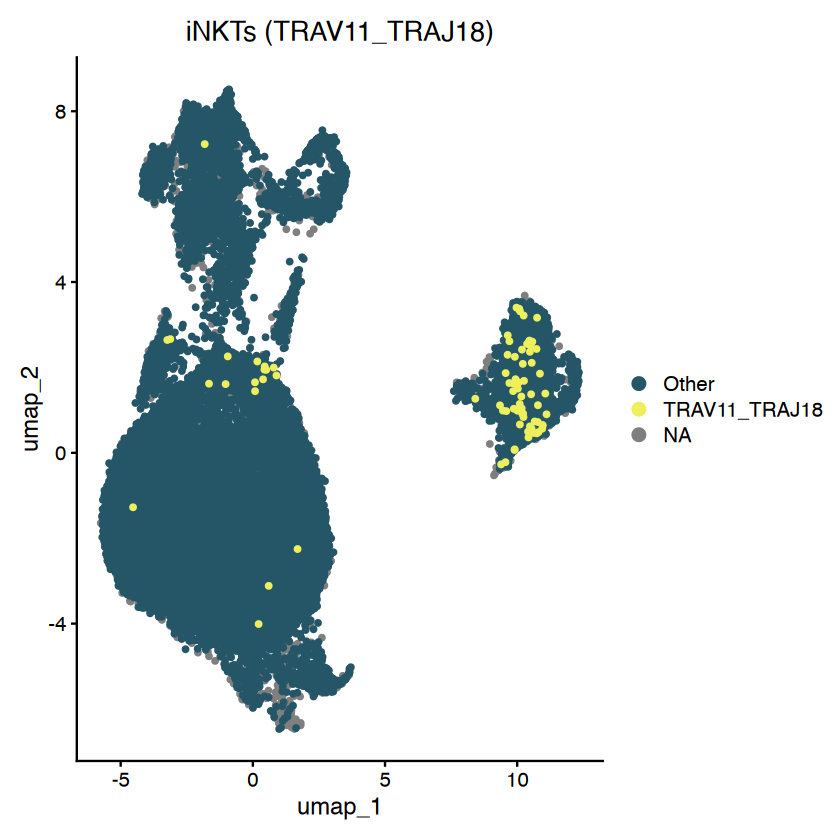

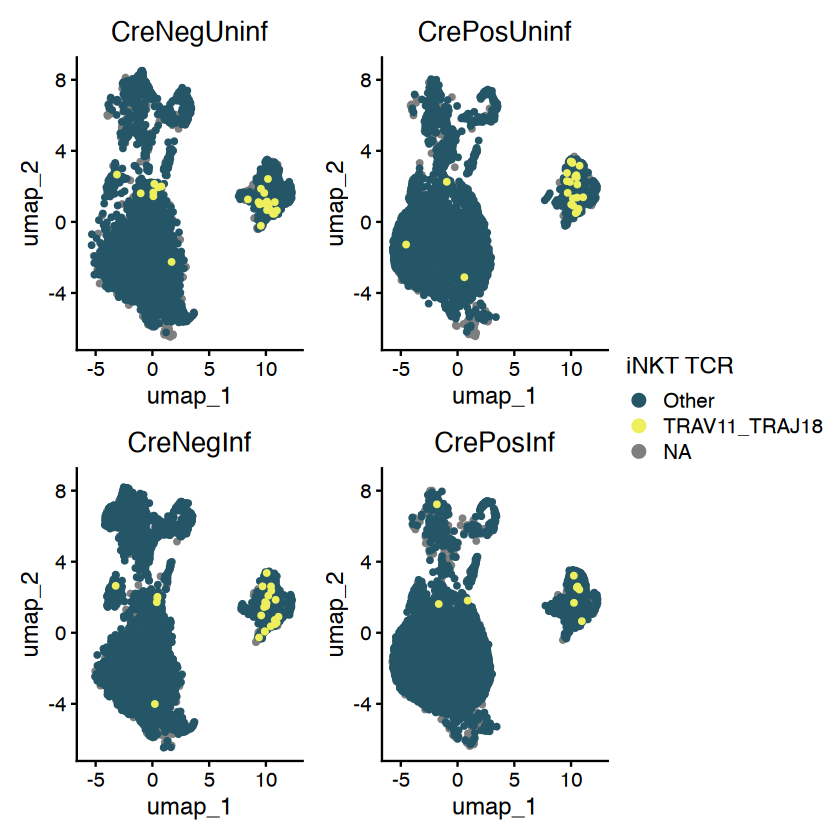

In [ ]:
#| fig.width: 8
#| fig.height: 5

Idents(seurat) <- 'CT_alpha_final'
seurat@meta.data <- mutate(seurat@meta.data, highlight=ifelse(CT_alpha_final == "TRAV11_TRAJ18", 'TRAV11_TRAJ18', 'Other'))

seurat$highlight <- factor(seurat$highlight, levels=c('Other','TRAV11_TRAJ18'))

DimPlot_scCustom(seurat, group.by = "highlight", order = T, pt.size = 1, colors_use = hcl.colors(n = 2, palette = 'ag_GrnYl')) + ggtitle('iNKTs (TRAV11_TRAJ18)')
ggsave(filename = 'UMAP_VDJ_iNKTs.pdf', width = 6, height = 5, path = figures_path)
DimPlot_scCustom(seurat, group.by = "highlight", order = T, pt.size = 1, colors_use = hcl.colors(n = 2, palette = 'ag_GrnYl'), split.by = 'condition') & labs(color = 'iNKT TCR')
ggsave(filename = 'UMAP_VDJ_iNKTs_by_group.pdf', width = 16, height = 1, path = figures_path)


### MAITs (TRAV1_TRAJ33)

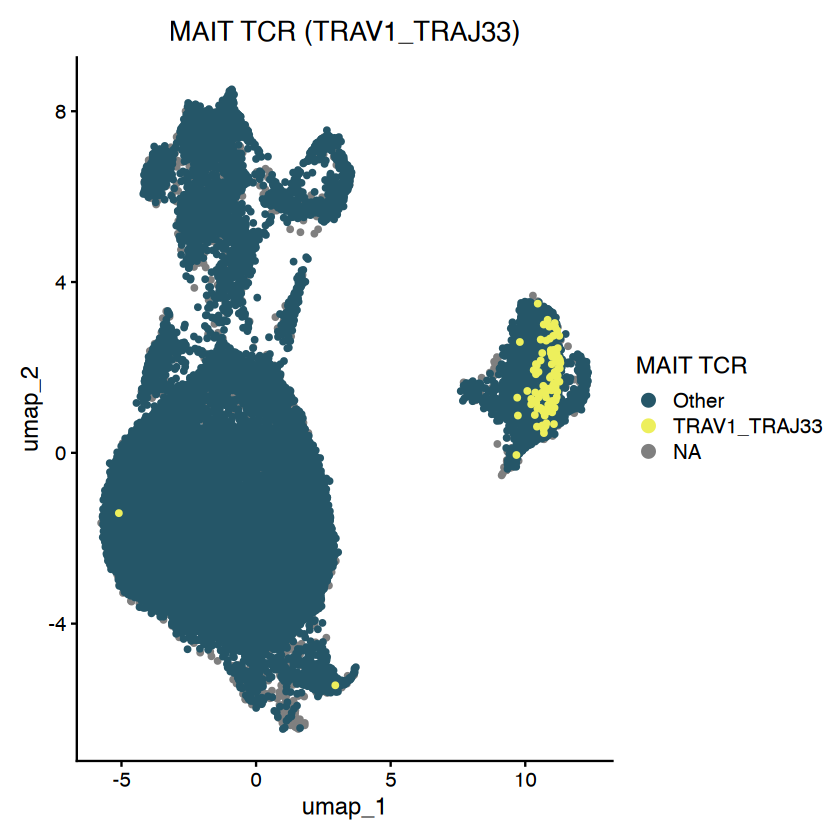

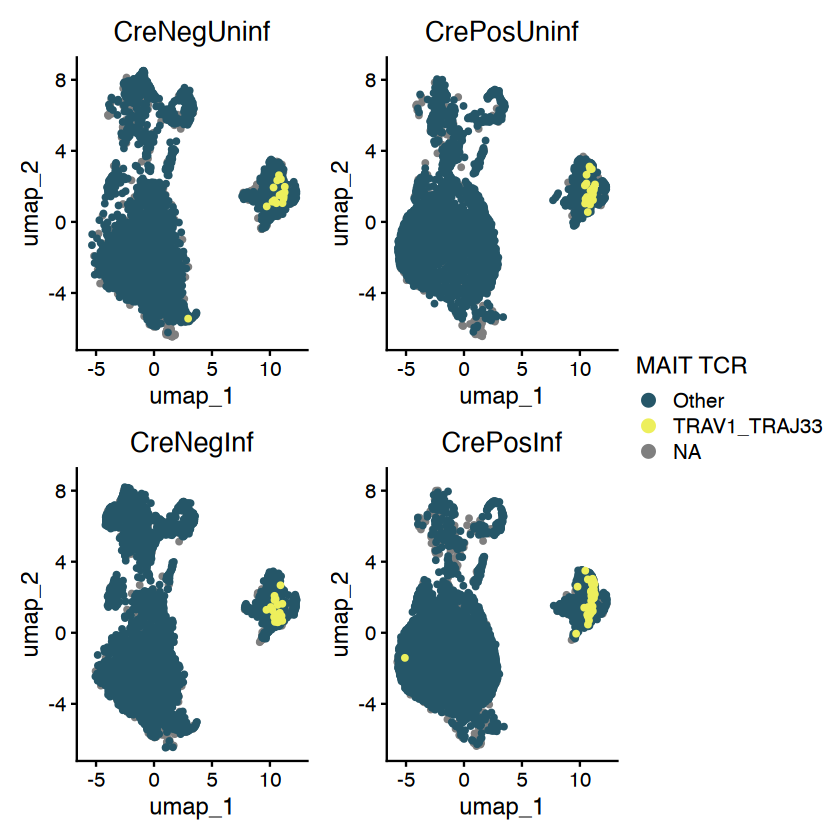

In [ ]:
#| fig.width: 8
#| fig.height: 5

#MAITs
Idents(seurat) <- 'CT_alpha_final'
seurat@meta.data <- mutate(seurat@meta.data, highlight_MAIT=ifelse(CT_alpha_final == "TRAV1_TRAJ33", 'TRAV1_TRAJ33', 'Other'))

seurat$highlight_MAIT <- factor(seurat$highlight_MAIT, levels=c('Other','TRAV1_TRAJ33'))
DimPlot_scCustom(seurat, group.by = "highlight_MAIT", order = T, pt.size = 1, colors_use = hcl.colors(n = 2, palette = 'ag_GrnYl')) + ggtitle('MAIT TCR (TRAV1_TRAJ33)') + labs(color = 'MAIT TCR')
ggsave(filename = 'UMAP_VDJ_MAIT.pdf', width = 6, height = 5, path = figures_path)
DimPlot_scCustom(seurat, group.by = "highlight_MAIT", order = T, pt.size = 1, colors_use = hcl.colors(n = 2, palette = 'ag_GrnYl'), split.by = 'condition') & labs(color = 'MAIT TCR')
ggsave(filename = 'UMAP_VDJ_MAIT_by_group.pdf', width = 16, height = 5, path = figures_path)

  
  

### QFLs (TRAV9D-3_TRAJ21)

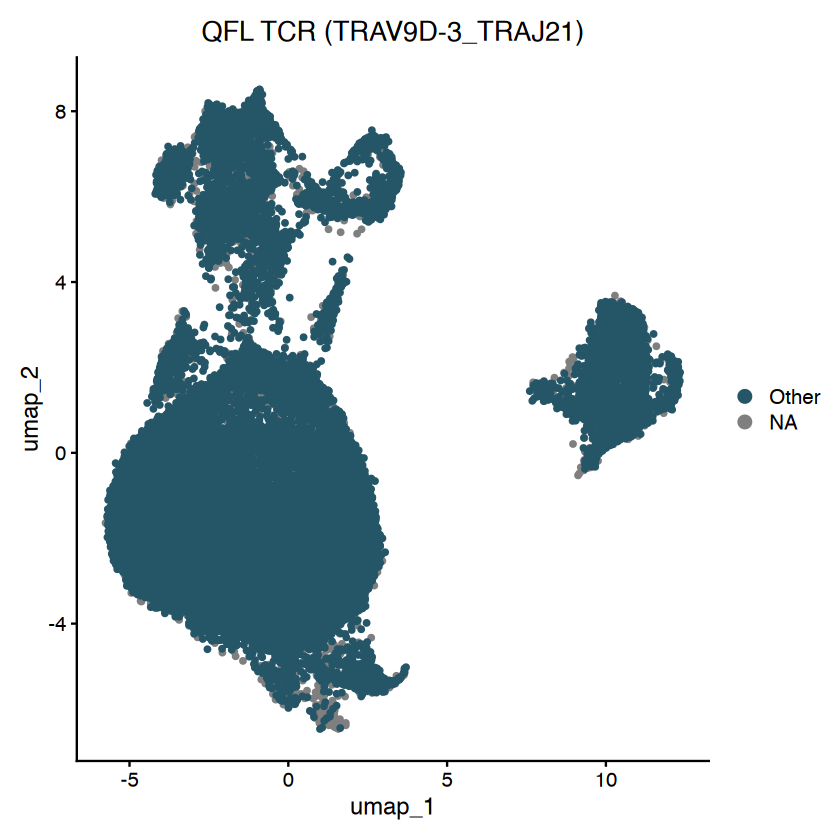

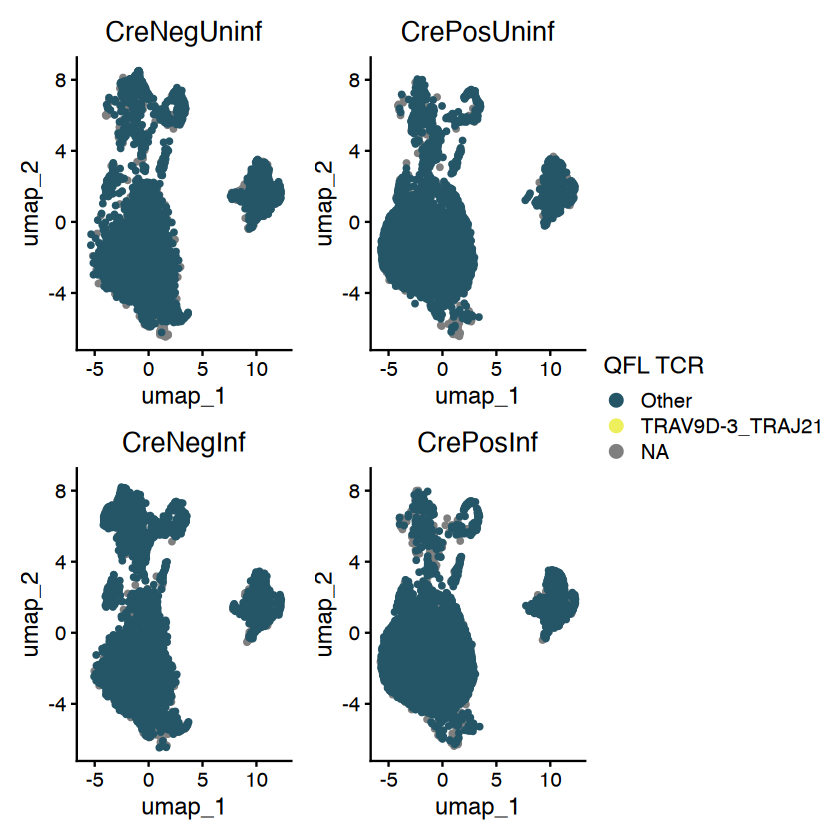

In [ ]:
#| fig.width: 8
#| fig.height: 5

#QFL
Idents(seurat) <- 'CT_alpha_final'
seurat@meta.data <- mutate(seurat@meta.data, highlight_QFL=ifelse(CT_alpha_final == "TRAV9D-3_TRAJ21", 'TRAV9D-3_TRAJ21', 'Other'))

seurat$highlight_QFL <- factor(seurat$highlight_QFL, levels=c('Other','TRAV9D-3_TRAJ21'))
DimPlot_scCustom(seurat, group.by = "highlight_QFL", order = T, pt.size = 1, colors_use = hcl.colors(n = 2, palette = 'ag_GrnYl')) + ggtitle('QFL TCR (TRAV9D-3_TRAJ21)')
ggsave(filename = 'UMAP_VDJ_QFL.pdf', width = 8, height = 5, path = figures_path)
DimPlot_scCustom(seurat, group.by = "highlight_QFL", order = T, pt.size = 1, colors_use = hcl.colors(n = 2, palette = 'ag_GrnYl'), split.by = 'condition') & labs(color = 'QFL TCR')
ggsave(filename = 'UMAP_VDJ_QFL_by_group.pdf', width = 16, height = 5, path = figures_path)

## Repertoire Diversity


### D50 diversity measure

In [ ]:
#| output: false
#Extracting TCR data for clusters of interest
Idents(seurat) <- 'major_cell_types'
combined2 <- scRepertoire:::.expression2List(seurat, split.by ='ident')

cell_types <- unique(seurat$major_cell_types)

#Initiating results data frame
results <- as.data.frame(matrix(nrow = 0,ncol = length(cell_types)))
# colnames(results)
rnames <- c()

#Calculate D50
for (HTO in unique(seurat$condition)) {
    
    result <- c()
    names <- c()

    for (cell_type in cell_types) {
        
        #Extracting data for cell type and HTO
        cell_type_HTO_data <- combined2[[cell_type]]|>
                                    filter(condition == HTO) |>
                                    dplyr::select(c('condition', 'CTaa')) |>
                                    add_count(CTaa, sort=TRUE)

        #Calculating D50
        if (nrow(cell_type_HTO_data) < 20) {
            D50 <- NA 
        } else {
            L50 <- floor(nrow(cell_type_HTO_data)/2)
            number_unique_50 <- cell_type_HTO_data[1:L50,] %>% summarise(n_distinct(CTaa)) %>% as.numeric()
            number_unique_total <- cell_type_HTO_data[] %>% summarise(n_distinct(CTaa)) %>% as.numeric()
            D50 <- number_unique_50/number_unique_total
        }
        result <- c(result, D50)
    }
    results <- rbind(results, result)
    rnames <- c(rnames, HTO)
    print(HTO)

}

results <- results %>% mutate(Mouse=rnames) %>% arrange(Mouse) |> relocate(Mouse)

write.csv(results, file=paste0(results_path, 'D50_per_major_cell_type.csv'), row.names=FALSE)


[1] "V1" "V2"

[1] "CrePosInf"
[1] "CreNegInf"
[1] "CrePosUninf"
[1] "CreNegUninf"
[1] "CrePosInf"   "CreNegInf"   "CrePosUninf" "CreNegUninf"


[1] 4

[1] "Type 1_D50"  "Type 17_D50"

Mouse       Type 1_D50 Type 17_D50
1 CreNegInf   0.2540480  0.4816000  
2 CreNegUninf 0.4377932  0.4743202  
3 CrePosInf   0.4837822  0.4732334  
4 CrePosUninf 0.4306956  0.4794776

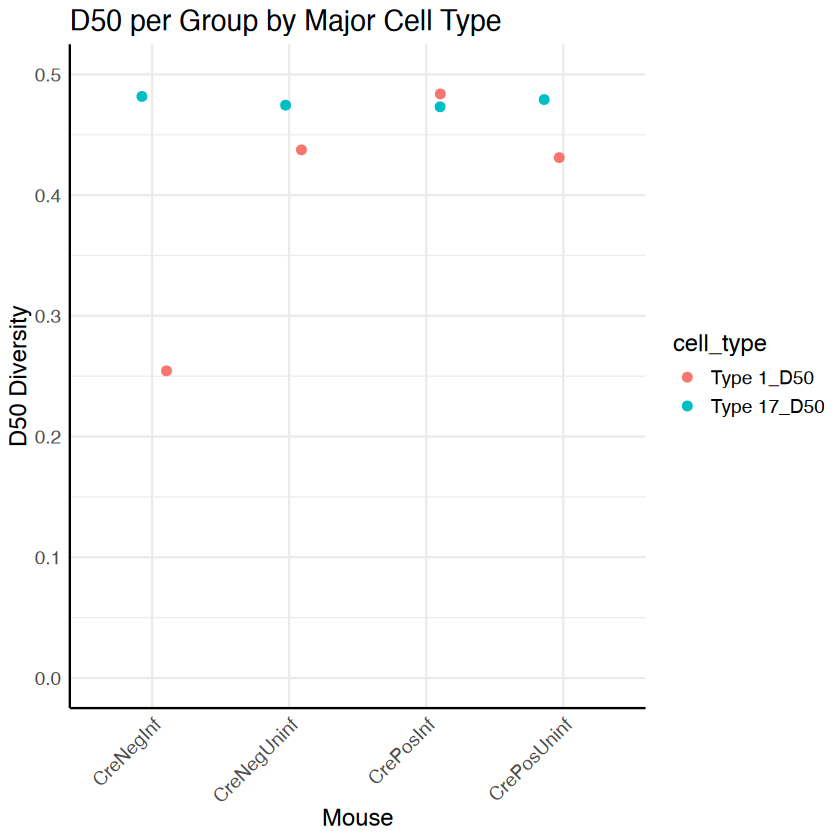

In [ ]:
#| fig-cap: 'Red: Type 1 D50, Blue: Type 17 D50'
# Convert results to long format for plotting
results_long <- results %>%
    pivot_longer(-Mouse, names_to = "cell_type", values_to = "D50")

# Remove NA values for plotting
results_long <- results_long %>% filter(!is.na(D50))

# Plot: x axis is Mouse, show only dots (no columns)
ggplot(results_long, aes(x = Mouse, y = D50, color = cell_type)) +
    geom_jitter(width = 0.15, size = 2, show.legend = TRUE) +
    theme_minimal() +
    labs(x = "Mouse", y = "D50 Diversity", title = "D50 per Group by Major Cell Type") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(size = 14),
          axis.line = element_line(colour = "black")) +
    scale_y_continuous(limits = c(0, 0.5))
ggsave(filename = paste0(figures_path, 'D50_per_major_cell_type.pdf'))

In [ ]:
#| output: false
#Extracting TCR data for clusters of interest
Idents(seurat) <- 'cell_types'
combined2 <- scRepertoire:::.expression2List(seurat, split.by ='ident')

cell_types <- unique(seurat$cell_types)

#Initiating results data frame
results <- as.data.frame(matrix(nrow = 0,ncol = length(cell_types)))
# colnames(results)
rnames <- c()

#Calculate D50
for (HTO in unique(seurat$condition)) {
    
    result <- c()
    names <- c()

    for (cell_type in cell_types) {
        
        #Extracting data for cell type and HTO
        cell_type_HTO_data <- combined2[[cell_type]]|>
                                    filter(condition == HTO) |>
                                    dplyr::select(c('condition', 'CTaa')) |>
                                    add_count(CTaa, sort=TRUE)

        #Calculating D50
        if (nrow(cell_type_HTO_data) < 20) {
            D50 <- NA 
        } else {
            L50 <- floor(nrow(cell_type_HTO_data)/2)
            number_unique_50 <- cell_type_HTO_data[1:L50,] %>% summarise(n_distinct(CTaa)) %>% as.numeric()
            number_unique_total <- cell_type_HTO_data[] %>% summarise(n_distinct(CTaa)) %>% as.numeric()
            D50 <- number_unique_50/number_unique_total
        }
        result <- c(result, D50)
    }
    results <- rbind(results, result)
    rnames <- c(rnames, HTO)
    print(HTO)

}

# print(rnames)
# nrow(results)
colnames(results) <- paste0(cell_types, '_D50')
# colnames(results)

results <- results %>% mutate(Mouse=rnames) %>% arrange(Mouse) |> relocate(Mouse)
results

write.csv(results, file=paste0(results_path, 'D50_per_cell_type.csv'), row.names=FALSE)


[1] "V1" "V2" "V3" "V4" "V5" "V6"

[1] "CrePosInf"
[1] "CreNegInf"
[1] "CrePosUninf"
[1] "CreNegUninf"
[1] "CrePosInf"   "CreNegInf"   "CrePosUninf" "CreNegUninf"


[1] 4

[1] "Type 1 DNs_D50"           "Cycling_D50"             
[3] "Activated Type 1 DNs_D50" "Type 17 DNs_D50"         
[5] "ISG_D50"                  "Other_D50"

Mouse       Type 1 DNs_D50 Cycling_D50 Activated Type 1 DNs_D50
1 CreNegInf   0.4946446      0.05434783  0.02424242              
2 CreNegUninf 0.4954105      0.25000000  0.05468750              
3 CrePosInf   0.4948133      0.40404040  0.11842105              
4 CrePosUninf 0.4917812      0.22222222  0.02752294              
  Type 17 DNs_D50 ISG_D50   Other_D50
1 0.4816000       0.4918033 0.4971751
2 0.4743202       0.5000000 0.4976959
3 0.4732334       0.5000000 0.4848485
4 0.4794776       0.5000000 0.4761905

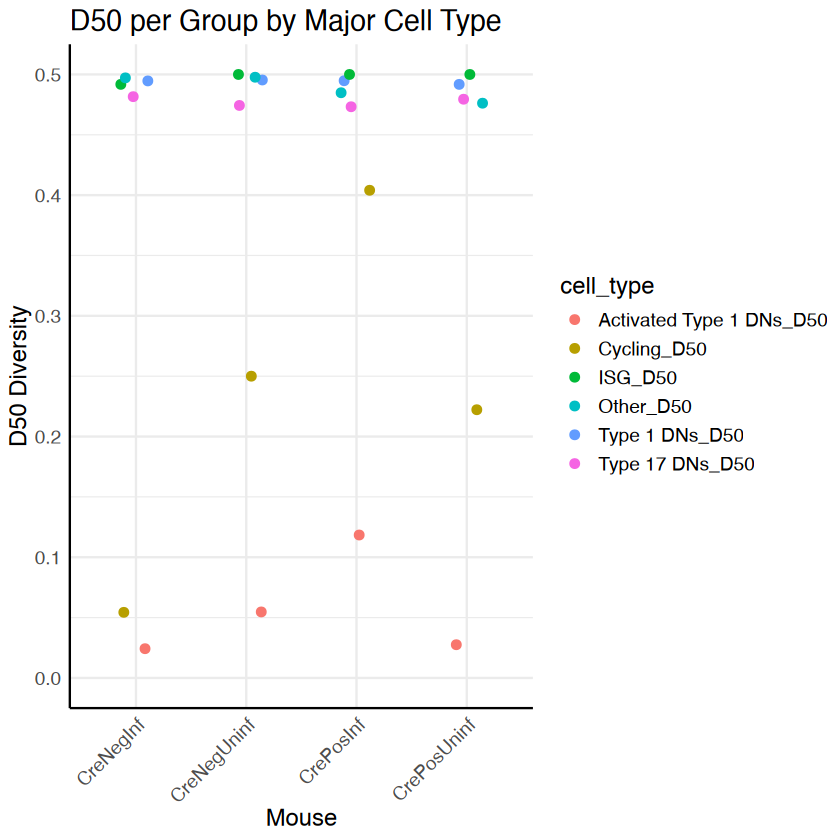

In [ ]:
# Convert results to long format for plotting
results_long <- results %>%
    pivot_longer(-Mouse, names_to = "cell_type", values_to = "D50")

# Remove NA values for plotting
results_long <- results_long %>% filter(!is.na(D50))

# Plot: x axis is Mouse, show only dots (no columns)
ggplot(results_long, aes(x = Mouse, y = D50, color = cell_type)) +
    geom_jitter(width = 0.15, size = 2, show.legend = TRUE) +
    theme_minimal() +
    labs(x = "Mouse", y = "D50 Diversity", title = "D50 per Group by Cell Type") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(size = 14),
          axis.line = element_line(colour = "black")) +
    scale_y_continuous(limits = c(0, 0.5)) +
    scale_color_manual(values = color_palette)


In [ ]:
#| include: false 
# #Extracting TCR data for clusters of interest
# Idents(scRNAseq) <- 'cell_types'
# combined2 <- scRepertoire:::.expression2List(scRNAseq, split.by ='ident')[

# diversity_measure_results <- clonalDiversity(combined2, cloneCall = 'aa', exportTable = T, n.boots = 100)
# #diversity_measure_results <- diversity_measure_results |>
#     #separate_wider_delim(Group, '_', names = c('cell_type', 'Sample'))
# write.csv(diversity_measure_results, file=paste0(path, 'diversity_measure_results.csv'), row.names=T)


## Overlap Analysis 

### Morisita Overlap Index of all cells

Saving 6.67 x 6.67 in image


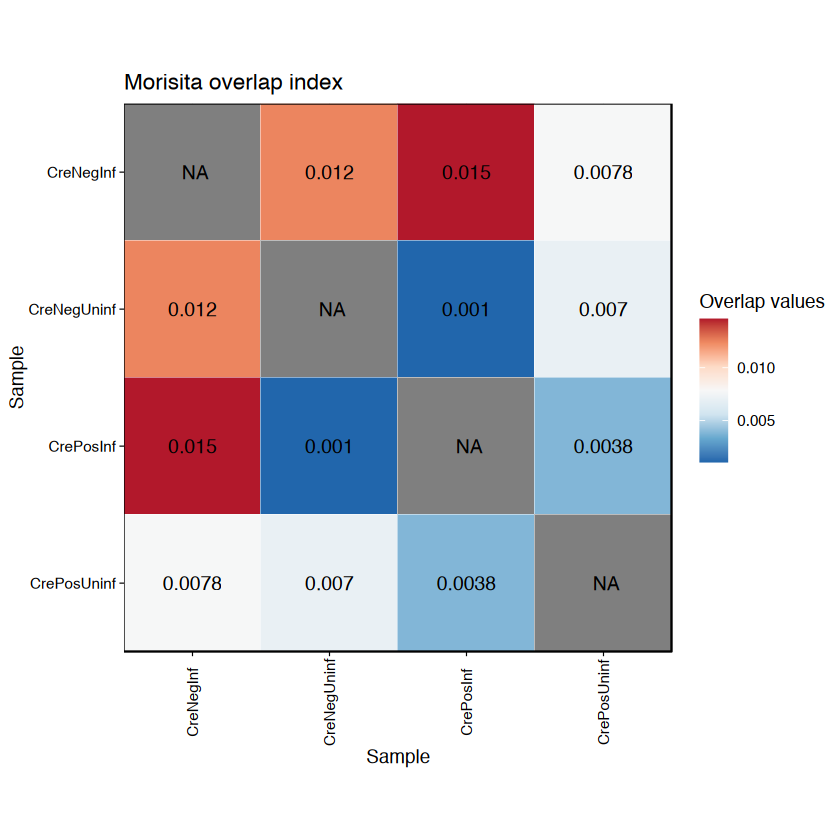

In [ ]:
immunarch_table <- exportClones(seurat, format = 'immunarch', write.file = FALSE, group.by = 'Groups')
overlap <- repOverlap(immunarch_table$data, .method = 'morisita', .verbose=FALSE)
vis(overlap) + ggtitle('Morisita overlap index')
ggsave(filename = paste0(figures_path, 'morisita_overlap.pdf'))


combined2 <- scRepertoire:::.expression2List(seurat, split.by ='condition')
morisita_table <- clonalOverlap(combined2, cloneCall = 'aa', chain = 'both',exportTable = T,method = 'morisita')
write.csv(morisita_table, file = paste0(results_path, 'morisita_table.csv'))

### Morisita Overlap Index of Activated Type 1 cluster only (Clonally Expanded)

Saving 6.67 x 6.67 in image


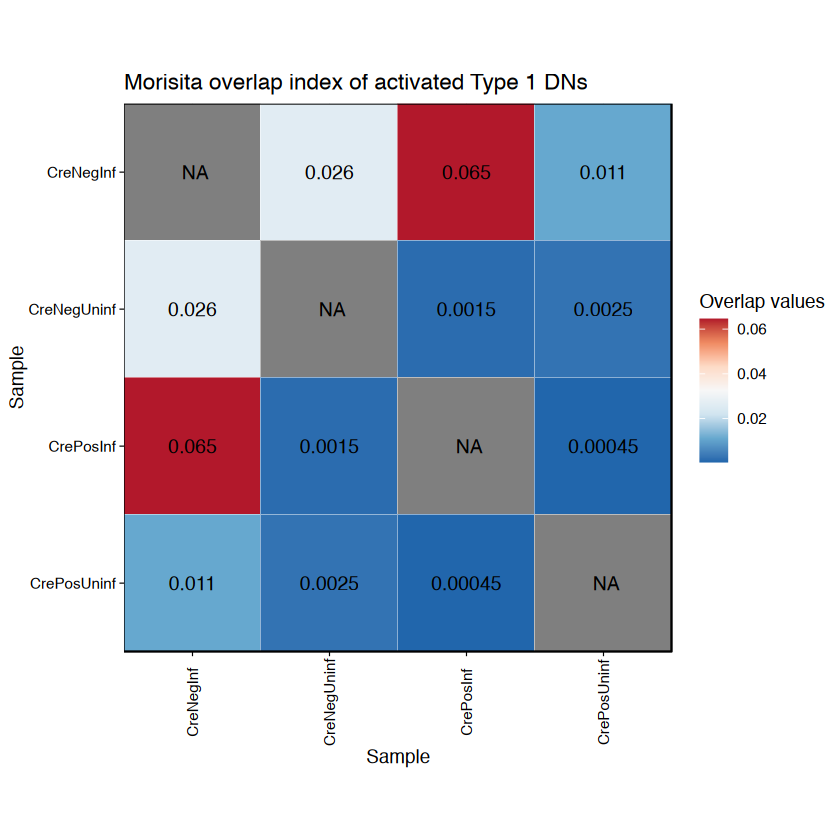

In [ ]:
immunarch_table <- exportClones(subset(seurat, subset=cell_types == 'Activated Type 1 DNs'), format = 'immunarch', write.file = FALSE, group.by = 'Groups')
overlap <- repOverlap(immunarch_table$data, .method = 'morisita', .verbose=FALSE)
vis(overlap) + ggtitle('Morisita overlap index of activated Type 1 DNs')
ggsave(filename = paste0(figures_path, 'morisita_overlap_activated_cluster.pdf'))


combined2 <- scRepertoire:::.expression2List(subset(seurat, subset=cell_types == 'Activated Type 1 DNs'), split.by ='condition')
morisita_table <- clonalOverlap(combined2, cloneCall = 'aa', chain = 'both',exportTable = T,method = 'morisita')
write.csv(morisita_table, file = paste0(results_path, 'morisita_table_activated_cluster.csv'))

### Overlap Coefficient Index of all cells

Saving 6.67 x 6.67 in image


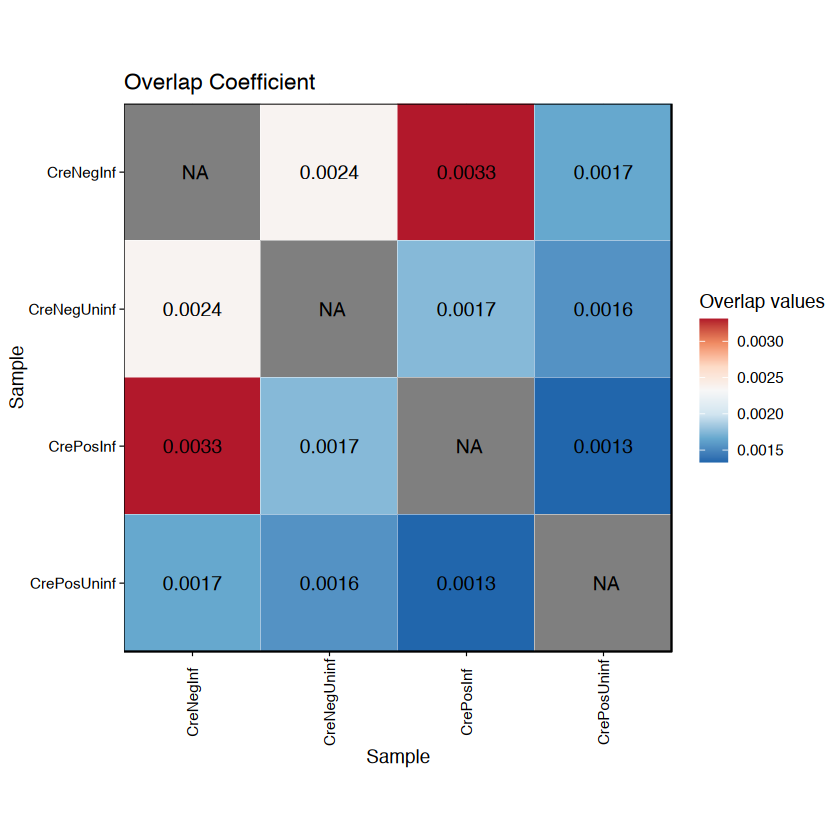

In [ ]:
immunarch_table <- exportClones(seurat, format = 'immunarch', write.file = FALSE, group.by = 'Groups')
overlap <- repOverlap(immunarch_table$data, .method = 'overlap', .verbose=FALSE)
vis(overlap) + ggtitle('Overlap Coefficient')
ggsave(filename = paste0(figures_path, 'overlap_coefficient.pdf'))


combined2 <- scRepertoire:::.expression2List(seurat, split.by ='condition')
overlap_coefficient <- clonalOverlap(combined2, cloneCall = 'aa', chain = 'both',exportTable = T,method = 'overlap')
write.csv(overlap_coefficient, file = paste0(results_path, 'overlap_coefficient.csv'))

### Overlap Coefficient Index of Activated Type 1 cluster only (Clonally Expanded)

Saving 6.67 x 6.67 in image


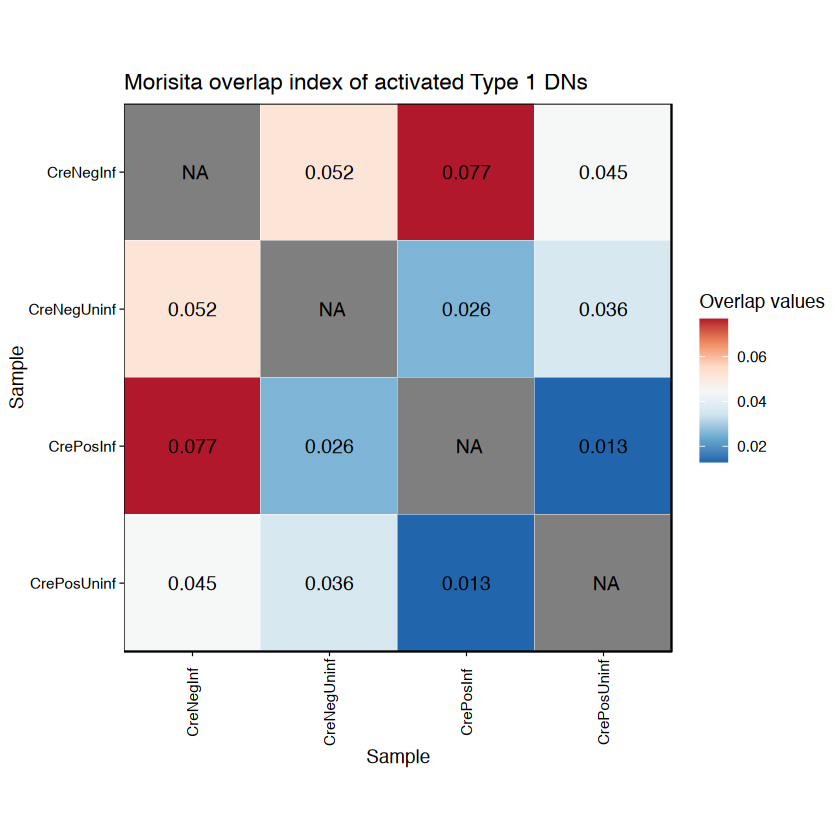

In [ ]:
immunarch_table <- exportClones(subset(seurat, subset=cell_types == 'Activated Type 1 DNs'), format = 'immunarch', write.file = FALSE, group.by = 'Groups')
overlap <- repOverlap(immunarch_table$data, .method = 'overlap', .verbose=FALSE)
vis(overlap) + ggtitle('Morisita overlap index of activated Type 1 DNs')
ggsave(filename = paste0(figures_path, 'overlap_coefficient_activated_cluster.pdf'))


combined2 <- scRepertoire:::.expression2List(subset(seurat, subset=cell_types == 'Activated Type 1 DNs'), split.by ='condition')
overlap_coefficient <- clonalOverlap(combined2, cloneCall = 'aa', chain = 'both',exportTable = T,method = 'overlap')
write.csv(overlap_coefficient, file = paste0(results_path, 'overlap_coefficient_activated_cluster.csv'))

## Visualizing Clonal Overlap: Circos plots

In [ ]:

mouse_palette <-c(
        'CreNegUninf' = 'skyblue1',
        'CrePosUninf' = 'skyblue4',
        'CreNegInf' = 'indianred1',
        'CrePosInf' = 'indianred4' 
        )

        

In [ ]:
# scRNAseq_small <- subset(seurat, subset =  seurat_clusters == '6', invert = T)
scRNAseq_small <- seurat
Idents(scRNAseq_small) <- 'Groups'
combined2 <- scRepertoire:::.expression2List(scRNAseq_small, split.by ='orig.ident')

#head(combined2[[1]])
# typeof(combined2[[1]]$clonalFrequency)

TCR_data <- combined2[[1]] |> 
    as_tibble() |>
    dplyr::select(c('CTaa', 'Groups', 'CTgene', 'clonalFrequency', 'cell_types'))  |>
    add_count(CTaa, Groups, sort = T,name = 'counts_per_condition') |>
#    add_count(CTaa, tissue, sort = T,name = 'counts_per_tissue') |>
    group_by(CTaa, ,Groups) |>
    slice_head() |>
    ungroup() |>
    arrange(desc(counts_per_condition))  |>
    pivot_wider(id_cols= c(CTaa) ,names_from = Groups, values_from = counts_per_condition,unused_fn = dplyr::first) |>
    #pivot_wider(id_cols= c(CTaa) ,names_from = tissue, values_from = counts_per_tissue, unused_fn = dplyr::first) |>
    mutate_all(~replace(., is.na(.), 0))  |>
    arrange(desc(clonalFrequency)) |>
    mutate(clonotype = paste0('clonotype ', as.character(row_number()) ))


# Th1_TCR_data <- Th1_TCR_data |> 
#     rowwise() |>
#     mutate(max=max(c_across(contains('rep'))),
#             GF_sum=sum(c_across(contains('GF-'))),
#             SPF_sum=sum(c_across(contains('SPF-')))) |>
#     ungroup() |>
#     mutate(spread=total_CTaa_counts-max,
#         Group_sharing=1-abs(GF_sum-SPF_sum)/total_CTaa_counts) |>
#     arrange( desc(Group_sharing))


    #dplyr::count(CTaa, Frequency, cloneType, Groups, Groups, sort = T)
    #distinct()

    # add_count(CTaa, sort=T)
#head( Th1_TCR_data |> filter(CTaa == 'CAANSNNRIFF_CASSLGASAETLYF') )
#head(TCR_data |> filter(skin > 0 & LN > 0 & spleen > 0))
#head(combined2[[1]] |> filter(CTaa == 'CAVRRGSALGRLHF_CASSLGEDTQYF') |> dplyr::select('CTgene'))

write_csv(TCR_data, file = paste0(results_path, 'TCR_data_per_group.csv'))
# typeof(TCR_data$clonalFrequency)

TCR_data_plot <- TCR_data |>
                    
                    pivot_longer(!c(CTaa, CTgene, clonalFrequency, clonotype,cell_types), names_to = 'mouse',values_to = 'mouse_counts')

# head(TCR_data_plot)
# typeof(TCR_data_plot$clonalFrequency)


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `cell_types = (structure(function (..., .x = ..1, .y = ..2, . =
  ..1) ...`.
Caused by warning in `[<-.factor`:
! invalid factor level, NA generated”


CTaa                          
1 CAASASSSFSKLVF_CASSPDWGGANEQYF
2 CAASASSSFSKLVF_CASSPDWGGANEQYF
3 CAASASSSFSKLVF_CASSPDWGGANEQYF
4 CAASASSSFSKLVF_CASSPDWGGANEQYF
5 CAASETGANTGKLTF_CASSPGHSGNTLYF
6 CAASETGANTGKLTF_CASSPGHSGNTLYF
  CTgene                                            clonalFrequency
1 TRAV14-2.TRAJ50.TRAC_TRBV12-1.TRBD2.TRBJ2-7.TRBC1 386            
2 TRAV14-2.TRAJ50.TRAC_TRBV12-1.TRBD2.TRBJ2-7.TRBC1 386            
3 TRAV14-2.TRAJ50.TRAC_TRBV12-1.TRBD2.TRBJ2-7.TRBC1 386            
4 TRAV14-2.TRAJ50.TRAC_TRBV12-1.TRBD2.TRBJ2-7.TRBC1 386            
5 TRAV5-4.TRAJ52.TRAC_TRBV12-1.NA.TRBJ1-3.TRBC1     319            
6 TRAV5-4.TRAJ52.TRAC_TRBV12-1.NA.TRBJ1-3.TRBC1     319            
  cell_types           clonotype   mouse       mouse_counts
1 Activated Type 1 DNs clonotype 1 CreNegInf   386         
2 Activated Type 1 DNs clonotype 1 CrePosUninf   2         
3 Activated Type 1 DNs clonotype 1 CreNegUninf   4         
4 Activated Type 1 DNs clonotype 1 CrePosInf     2         
5 Activated Type 1 DNs clonotype 2 CreNegInf   319         
6 Activated Type 1 DNs clonotype 2 CrePosUninf   0

Circos

In [ ]:
# unique(TCR_data_plot$mouse)
TCR_data_plot_old <- TCR_data_plot
# unique(TCR_data_plot_old$mouse)
TCR_data_plot <- TCR_data_plot |>
    #filter(skin > 0) |>
    group_by(mouse) |>
    mutate(TCR_sequence_count_by_cell_type = sum(mouse_counts)) |>
    arrange(desc(mouse_counts)) |>
    mutate(TCR_sequence_position_by_cell_type = cumsum(mouse_counts))  |>
    mutate(TCR_sequence_start_position_by_cell_type =  c(0, TCR_sequence_position_by_cell_type[-length(TCR_sequence_position_by_cell_type)]))   |>
    ungroup() |>
    rowwise() |> 
    mutate(coordinates = list(c(TCR_sequence_start_position_by_cell_type, TCR_sequence_position_by_cell_type))) |>
    ungroup() |>
    mutate(mouse = factor(mouse, levels = c(      
                                                'CreNegUninf', 'CrePosUninf', 'CrePosInf', 'CreNegInf')))  #|> 
    #filter(!(mouse %in% c('Naive', 'activated T cells', 'TCM', 'Th1')))
    




#head(TCR_data_plot |> arrange(mouse_counts) |> filter(mouse == 'Tregs'), 30)
#tail(TCR_data_plot |> filter(mouse == 'Naive'))
# levels(TCR_data_plot$mouse)

In [ ]:
TCR_data_plot_distinct <- TCR_data_plot |> dplyr::select(c('mouse', 'TCR_sequence_count_by_cell_type')) |> distinct() |> arrange(mouse) |> mutate(origin = TCR_sequence_count_by_cell_type*0) |> column_to_rownames('mouse') |> relocate(origin)  |> as.matrix()
# head(TCR_data_plot_distinct, 12)

In [ ]:
#| include: false
 
###########Circos####################
cluster <- 'all'

plot <- pdf(file = paste0(figures_path, 'Circos_TCR_per_condition', '.pdf')) #Initialize plot

# Setting parameters
circos.par(gap.degree = 2, track.height = 0.1, cell.padding = c(0, 0, 0, 0), circle.margin = 0.2)

# Initializing plot sectors
circos.initialize(xlim = TCR_data_plot_distinct)

#Assigning colors to each cluster
#grid_cols <- scales::hue_pal()(length(levels(TCR_data_plot$mouse))) #|> rev()
    #names(grid_cols) <- levels(TCR_data_plot$mouse)

grid_cols <- mouse_palette
names(grid_cols) <- levels(seurat$condition)

#Drawing axes 
circos.track(ylim = c(0,1),
 panel.fun = function(x, y) {
        print(CELL_META$xrange[[1]])
        
        if (CELL_META$cell.width < 45) {
            circos.text(CELL_META$xcenter, 
            CELL_META$cell.ylim[2] + mm_y(10), 
            adj = c(0 , 1),
            CELL_META$sector.index,
            facing = 'clockwise', 
            niceFacing = T, 
            cex  = 0.7)



        } else {
            circos.text(CELL_META$xcenter, 
            CELL_META$cell.ylim[2] + mm_y(11),
            #adj = c(0, 1), 
            CELL_META$sector.index,
            facing = 'bending.inside', 
            niceFacing = T,
            cex = 0.8
            )

        }

        if (CELL_META$xrange[[1]] > 500) {
            circos.axis(labels.cex = 0.5, 
            minor.ticks =  0,
            major.tick = 1,
            labels.facing = 'clockwise',
            major.at = seq(500, CELL_META$xrange[[1]], by = 500))
        }

        highlight.sector(CELL_META$sector.index, col = grid_cols[CELL_META$sector.index])
    })

done <- c() #To avoid plotting the same link twice

# Plot links between mice
for (origin in levels(TCR_data_plot$mouse)) {
    for (target in levels(TCR_data_plot$mouse)) {
        if (origin == target | target %in% done) {
            next
        }    else {
                table_one <- TCR_data_plot |>
                filter(mouse == origin & mouse_counts != 0)  |>
                dplyr::select(c('clonotype', 'mouse', 'coordinates', 'cell_types')) 
        
                table_two <- TCR_data_plot |>
                filter(mouse == target & mouse_counts != 0) |>
                dplyr::select(c('clonotype', 'mouse', 'coordinates', 'cell_types'))

                link_table  <-  inner_join(table_one, table_two, by = 'clonotype') |> column_to_rownames(var = 'clonotype')

                # if (str_detect(origin, 'Activated Type 1 DNs') | str_detect(target, 'Activated Type 1 DNs')) {
                #     color = alpha(color_palette['Activated Type 1 DNs'], 0.5)}                    
                # else {
                #     color = alpha("gray", 0.15)
                # }

                # color = alpha(grid_cols[origin], 0.5)

                for (clonotype1 in rownames(link_table)) {
                    
                    index1 <- link_table[[clonotype1, 'mouse.x']]
                    index2 <- link_table[[clonotype1, 'mouse.y']]
                    coordinates1 <- as.vector(link_table[[clonotype1, 'coordinates.x']])
                    coordinates2 <- as.vector(link_table[[clonotype1, 'coordinates.y']])

                    # Assign color based on origin and target
                    if (str_detect(link_table[[clonotype1, 'cell_types.x']], 'Activated Type 1 DNs') | 
                        str_detect(link_table[[clonotype1, 'cell_types.y']], 'Activated Type 1 DNs') |
                        str_detect(link_table[[clonotype1, 'cell_types.x']], 'Cycling') |
                        str_detect(link_table[[clonotype1, 'cell_types.y']], 'Cycling') 
                        ) {
                        color = alpha(color_palette['Activated Type 1 DNs'], 0.5)}                    
                    else {
                        color = alpha("gray", 0.25)
                    }

                    # Plot link
                    circos.link(link_table[[clonotype1, 'mouse.x']], 
                                as.vector(link_table[[clonotype1, 'coordinates.x']]),
                                link_table[[clonotype1, 'mouse.y']],
                                as.vector(link_table[[clonotype1, 'coordinates.y']]),
                                col = color)
                }

        }
    }
    
     done <- c(done, origin)

}
    
title(paste0('TCR Overlap ', cluster, ' per mouse'))

circos.clear()


dev.off()

circos.clear()


[1] 5730


Note: 1 point is out of plotting region in sector 'CreNegUninf', track
'1'.

Note: 1 point is out of plotting region in sector 'CreNegUninf', track
'1'.

Note: 11 points are out of plotting region in sector 'CreNegUninf',
track '1'.



[1] 5074


Note: 1 point is out of plotting region in sector 'CrePosUninf', track
'1'.

Note: 1 point is out of plotting region in sector 'CrePosUninf', track
'1'.

Note: 11 points are out of plotting region in sector 'CrePosUninf',
track '1'.



[1] 5743


Note: 1 point is out of plotting region in sector 'CrePosInf', track
'1'.

Note: 1 point is out of plotting region in sector 'CrePosInf', track
'1'.

Note: 9 points are out of plotting region in sector 'CrePosInf', track
'1'.



[1] 5991


Note: 1 point is out of plotting region in sector 'CreNegInf', track
'1'.

Note: 1 point is out of plotting region in sector 'CreNegInf', track
'1'.

Note: 9 points are out of plotting region in sector 'CreNegInf', track
'1'.



agg_record_2132988918 
                    2

[1] 5730


Note: 1 point is out of plotting region in sector 'CreNegUninf', track
'1'.

Note: 1 point is out of plotting region in sector 'CreNegUninf', track
'1'.

Note: 11 points are out of plotting region in sector 'CreNegUninf',
track '1'.



[1] 5074


Note: 1 point is out of plotting region in sector 'CrePosUninf', track
'1'.

Note: 1 point is out of plotting region in sector 'CrePosUninf', track
'1'.

Note: 11 points are out of plotting region in sector 'CrePosUninf',
track '1'.



[1] 5743


Note: 1 point is out of plotting region in sector 'CrePosInf', track
'1'.

Note: 1 point is out of plotting region in sector 'CrePosInf', track
'1'.

Note: 9 points are out of plotting region in sector 'CrePosInf', track
'1'.



[1] 5991


Note: 1 point is out of plotting region in sector 'CreNegInf', track
'1'.

Note: 1 point is out of plotting region in sector 'CreNegInf', track
'1'.

Note: 9 points are out of plotting region in sector 'CreNegInf', track
'1'.



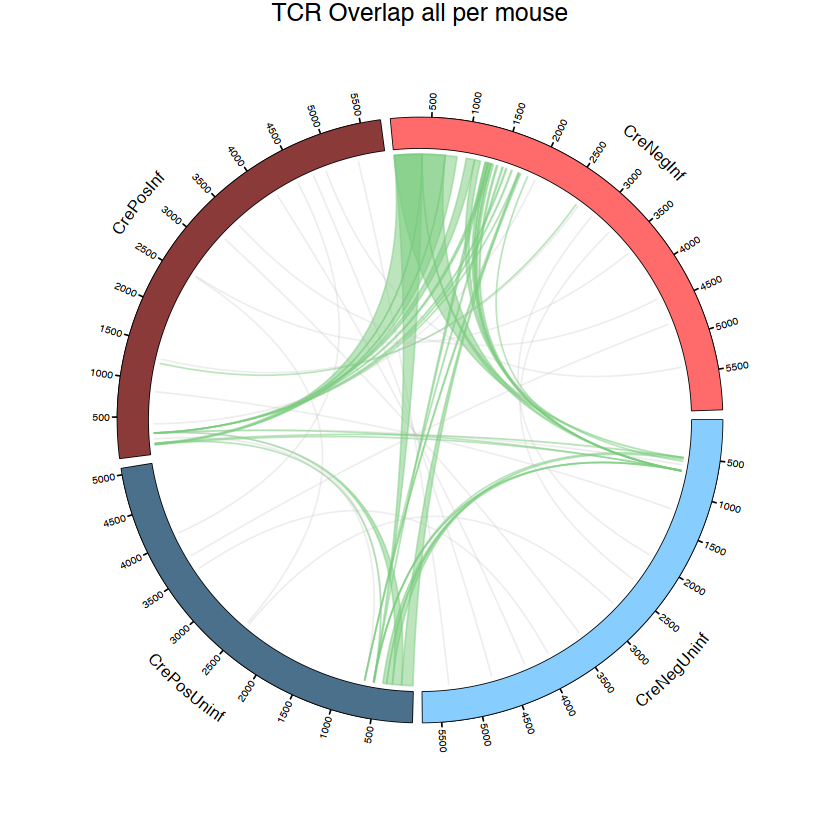

In [ ]:
#| fig-cap: Links represent TCR sequences shared between mice. The size of the link at each end is proportional to the number of cells sharing the same TCR sequence for that sample. Green links represent TCR sequences shared between activated Type 1 DNs and/or Cycling (at either end), while gray links represent TCR sequences shared between other cell types.
#| results: false

###########Circos####################
#path <- './'
cluster <- 'all'

# Setting parameters
circos.par(gap.degree = 2, track.height = 0.1, cell.padding = c(0, 0, 0, 0), circle.margin = 0.2)

# Initializing plot sectors
circos.initialize(xlim = TCR_data_plot_distinct)

#Assigning colors to each cluster
#grid_cols <- scales::hue_pal()(length(levels(TCR_data_plot$mouse))) #|> rev()
    #names(grid_cols) <- levels(TCR_data_plot$mouse)

grid_cols <- mouse_palette
names(grid_cols) <- levels(seurat$condition)

#Drawing axes 
circos.track(ylim = c(0,1),
 panel.fun = function(x, y) {
        print(CELL_META$xrange[[1]])
        
        if (CELL_META$cell.width < 45) {
            circos.text(CELL_META$xcenter, 
            CELL_META$cell.ylim[2] + mm_y(10), 
            adj = c(0 , 1),
            CELL_META$sector.index,
            facing = 'clockwise', 
            niceFacing = T, 
            cex  = 0.7)



        } else {
            circos.text(CELL_META$xcenter, 
            CELL_META$cell.ylim[2] + mm_y(11),
            #adj = c(0, 1), 
            CELL_META$sector.index,
            facing = 'bending.inside', 
            niceFacing = T,
            cex = 0.8
            )

        }

        if (CELL_META$xrange[[1]] > 500) {
            circos.axis(labels.cex = 0.5, 
            minor.ticks =  0,
            major.tick = 1,
            labels.facing = 'clockwise',
            major.at = seq(500, CELL_META$xrange[[1]], by = 500))
        }

        highlight.sector(CELL_META$sector.index, col = grid_cols[CELL_META$sector.index])
    })

done <- c() #To avoid plotting the same link twice

# Plot links between mice
for (origin in levels(TCR_data_plot$mouse)) {
    for (target in levels(TCR_data_plot$mouse)) {
        if (origin == target | target %in% done) {
            next
        }    else {
                table_one <- TCR_data_plot |>
                filter(mouse == origin & mouse_counts != 0)  |>
                dplyr::select(c('clonotype', 'mouse', 'coordinates', 'cell_types')) 
        
                table_two <- TCR_data_plot |>
                filter(mouse == target & mouse_counts != 0) |>
                dplyr::select(c('clonotype', 'mouse', 'coordinates', 'cell_types'))

                link_table  <-  inner_join(table_one, table_two, by = 'clonotype') |> column_to_rownames(var = 'clonotype')

                # if (str_detect(origin, 'Activated Type 1 DNs') | str_detect(target, 'Activated Type 1 DNs')) {
                #     color = alpha(color_palette['Activated Type 1 DNs'], 0.5)}                    
                # else {
                #     color = alpha("gray", 0.15)
                # }

                # color = alpha(grid_cols[origin], 0.5)

                for (clonotype1 in rownames(link_table)) {
                    
                    index1 <- link_table[[clonotype1, 'mouse.x']]
                    index2 <- link_table[[clonotype1, 'mouse.y']]
                    coordinates1 <- as.vector(link_table[[clonotype1, 'coordinates.x']])
                    coordinates2 <- as.vector(link_table[[clonotype1, 'coordinates.y']])

                    # Assign color based on origin and target
                    if (str_detect(link_table[[clonotype1, 'cell_types.x']], 'Activated Type 1 DNs') | 
                        str_detect(link_table[[clonotype1, 'cell_types.y']], 'Activated Type 1 DNs') |
                        str_detect(link_table[[clonotype1, 'cell_types.x']], 'Cycling') |
                        str_detect(link_table[[clonotype1, 'cell_types.y']], 'Cycling') 
                        ) {
                        color = alpha(color_palette['Activated Type 1 DNs'], 0.5)}                    
                    else {
                        color = alpha("gray", 0.25)
                    }

                    # Plot link
                    circos.link(link_table[[clonotype1, 'mouse.x']], 
                                as.vector(link_table[[clonotype1, 'coordinates.x']]),
                                link_table[[clonotype1, 'mouse.y']],
                                as.vector(link_table[[clonotype1, 'coordinates.y']]),
                                col = color)
                }

        }
    }
    
     done <- c(done, origin)

}
    
title(paste0('TCR Overlap ', cluster, ' per mouse'))

circos.clear()


## Gene usage analysis

### TRBV gene usage

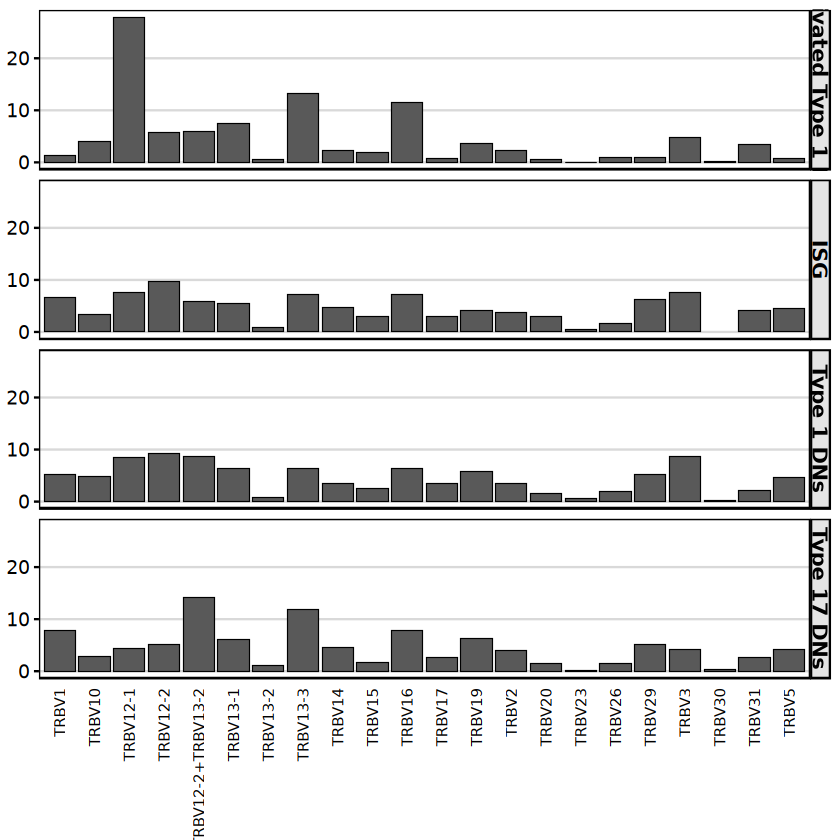

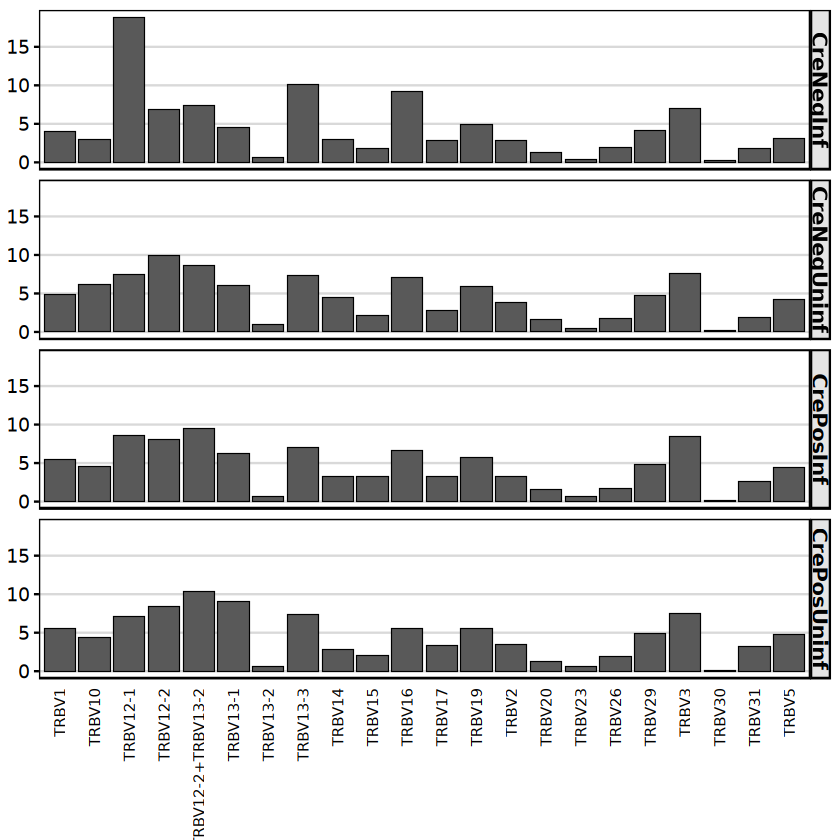

In [ ]:
#| fig.width: 5
#| fig.height: 8

seurat_small <- subset(seurat, subset = cell_types %in% c( 'Activated Type 1 DNs', 'Type 1 DNs', 'Type 17 DNs', 'ISG'))

combined2 <- scRepertoire:::.expression2List(seurat_small, split.by ='cell_types')

vizGenes(combined2,
         x.axis = "TRBV",
         y.axis = NULL, # No specific y-axis variable, will group all samples
         plot = "barplot",
         summary.fun = "percent") 

ggsave(filename = paste0(figures_path, 'TRBV_gene_usage_per_cell_type.pdf'), width = 8, height = 5)

seurat_small <- subset(seurat, subset = cell_types %in% c( 'Activated Type 1 DNs', 'Type 1 DNs', 'Type 17 DNs', 'ISG'))

combined4 <- scRepertoire:::.expression2List(seurat_small, split.by ='Groups')

vizGenes(combined4,
         x.axis = "TRBV",
         y.axis = NULL, # No specific y-axis variable, will group all samples
         plot = "barplot",
         summary.fun = "percent") 

ggsave(filename = paste0(figures_path, 'TRBV_gene_usage_per_group.pdf'), width = 8, height = 5)

### TRBV TRBJ gene parings

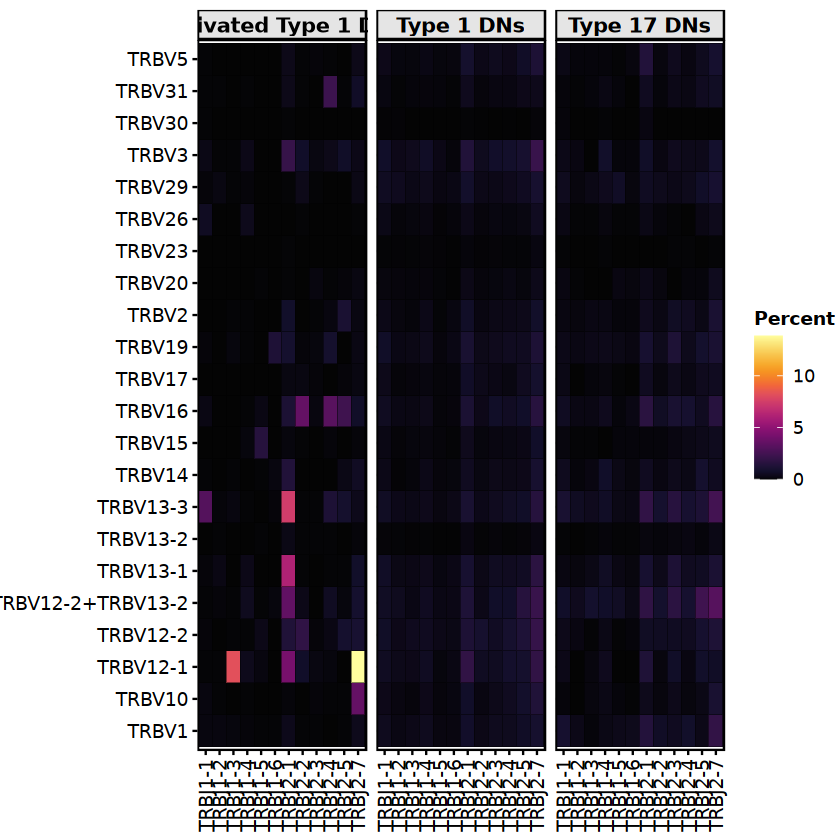

In [ ]:
#| fig.width: 9
#| fig.height: 6
combined3 <- combined2[c((c('Activated Type 1 DNs', 'Type 1 DNs', 'Type 17 DNs')))]
vizGenes(combined3,
         x.axis = "TRBV",
         y.axis = "TRBJ",
         plot = "heatmap",
         summary.fun = "percent") # Display percentages

ggsave(filename = paste0(figures_path, 'TRBV_TRBJ_gene_pairings.pdf'), width = 9, height = 6)

### TRAV gene usage

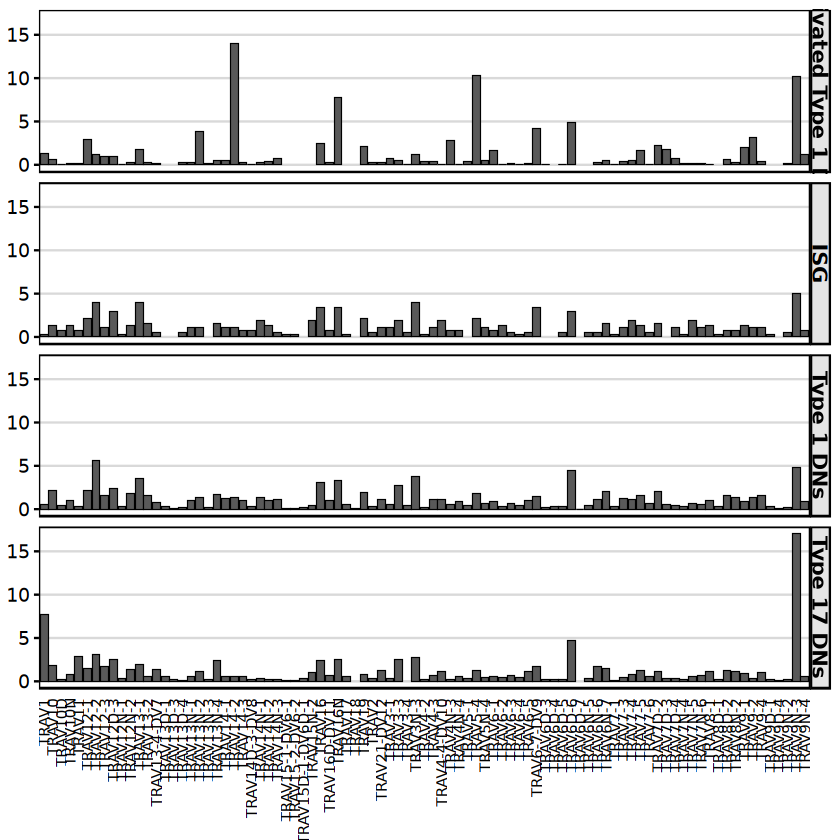

In [ ]:
#| fig.width: 8
#| fig.height: 10

seurat_small <- subset(seurat, subset = cell_types %in% c( 'Activated Type 1 DNs', 'Type 1 DNs', 'Type 17 DNs', 'ISG'))

combined2 <- scRepertoire:::.expression2List(seurat_small, split.by ='cell_types')

vizGenes(combined2,
         x.axis = "TRAV",
         y.axis = NULL, # No specific y-axis variable, will group all samples
         plot = "barplot",
         summary.fun = "percent") 

ggsave(filename = paste0(figures_path, 'TRAV_gene_usage_barplot.pdf'), width = 10, height = 6)

### TRAV TRAJ gene parings

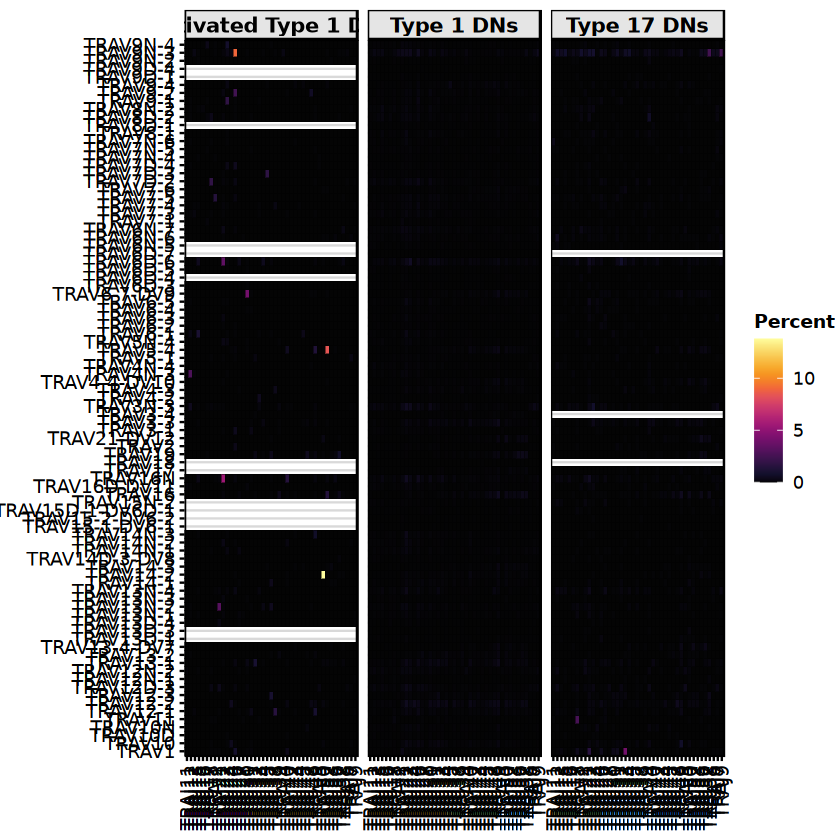

In [ ]:
#| fig.width: 12
#| fig.height: 20

combined3 <- combined2[c((c('Activated Type 1 DNs', 'Type 1 DNs', 'Type 17 DNs')))]
vizGenes(combined3,
         x.axis = "TRAV",
         y.axis = "TRAJ",
         plot = "heatmap",
         summary.fun = "percent") # Display percentages

ggsave(filename = paste0(figures_path, 'TRAV_TRAJ_pairings_heatmap.pdf'), width = 12, height = 20)

## Expanded Clonotypes

### Top 20 expanded clonotypes

Please note the clonotypes are defined at the level of the Amino Acid CDR3 region only. The label cell type is just one cell type where this clonotype is found, not necessarily the most abundant.

 The presence of a clonotype across multiple groups is surprising, but not unprecedented, With a caveat that some of them could be errors in demultiplexing of the hashtags.

In [ ]:
head(TCR_data, n = 30) |> knitr::kable()


CTaa                               CreNegInf CrePosUninf CreNegUninf
1  CAASASSSFSKLVF_CASSPDWGGANEQYF     386         2          4         
2  CAASETGANTGKLTF_CASSPGHSGNTLYF     319         0          1         
3  CAVSLNNYAQGLTF_CASSDPGLGGNYAEQFF   165         0          0         
4  CAMREAGSWQLIF_CASSDDRGYAEQFF         3       160          0         
5  CALGDPSGSWQLIF_CASSSQGRATGQLYF     128         0          0         
6  CAVSRNYAQGLTF_CASGDAEWGGYAEQFF       0       127          0         
7  CALSPDDTNAYKVIF_CASSPWDRGRAEQFF    118         0          0         
8  CAIDWSNYNVLYF_CASTTGGWEQYF           0         0         93         
9  CAAEAGTGGYKVVF_CASRNRGVTEVFF        83         0          2         
10 CVLSYNYAQGLTF_CAWSLWGQNTLYF          0        79          3         
11 CAALTGFASALTF_CASSSGLSYAEQFF        67         0          0         
12 CALSGHNVGDNSKLIW_CASSSGQGFNQAPLF     0         0          0         
13 CAVSGDYNQGKLIF_CASSRDWGGPGQLYF       0         0         55         
14 CAAHRGSALGRLHF_CASTIGAEQFF           0        54          1         
15 CVLGNWGQGGRALIF_CASSWTGYYAEQFF       0         0         45         
16 CAVSNTGGLSGKLTF_CASSLGGGTQYF         0         0         44         
17 CAMRGGVNTGNYKYVF_CASSLRDWGLSQNTLYF  43         2          1         
18 CAPSTGANTGKLTF_CASSLRDWGLSQNTLYF    41         0          1         
19 CALGSYGSSGNKLIF_CASSQDRNQDTQYF       0         0         37         
20 CAATGGYQNFYF_CASSISGALNSPLYF         0         0         35         
21 CALRGPNTGYQNFYF_CASSVGGPDTQYF        0         0         33         
22 CALSMSWYNQGKLIF_CASSDWDWVQNTLYF     33         0          1         
23 CAVRNNYAQGLTF_CASSPGLGNYAEQFF       26         0          0         
24 CALMAGNTGKLIF_CASSVGGGYAEQFF         0         0         25         
25 CAASVGNYAQGLTF_CASSQENWFNYAEQFF      0         0         19         
26 CAASPNTGYQNFYF_CASSLRGPGQLYF         0         0         18         
27 CAASRGTASLGKLQF_CASSLWNERLFF        18         0          0         
28 CVLSAKYGNEKITF_CASSGGATQYF          18         0          1         
29 CAPTTASLGKLQF_CASGDRGPNERLFF        17         0          0         
30 CVLSLPGNTGKLIF_CASSRDWGQDTQYF       17         0          0         
   CrePosInf CTgene                                                    
1   2        TRAV14-2.TRAJ50.TRAC_TRBV12-1.TRBD2.TRBJ2-7.TRBC1         
2   3        TRAV5-4.TRAJ52.TRAC_TRBV12-1.NA.TRBJ1-3.TRBC1             
3   3        TRAV9N-3.TRAJ26.TRAC_TRBV13-3.TRBD2.TRBJ2-1.TRBC1         
4   0        TRAV16N.TRAJ22.TRAC_TRBV13-1.NA.TRBJ2-1.TRBC1             
5   0        TRAV6D-6.TRAJ22.TRAC_TRBV16.NA.TRBJ2-2.TRBC1              
6   1        TRAV9N-3.TRAJ26.TRAC_TRBV12-2+TRBV13-2.NA.TRBJ2-1.TRBC1   
7   1        TRAV6-7-DV9.TRAJ30.TRAC_TRBV12-1.TRBD1.TRBJ2-1.TRBC1      
8   0        TRAV13N-2.TRAJ21.TRAC_TRBV10.NA.TRBJ2-7.TRBC1             
9   0        TRAV4N-3.TRAJ12.TRAC_TRBV13-3.NA.TRBJ1-1.TRBC1            
10  0        TRAV9-2.TRAJ26.TRAC_TRBV31.NA.TRBJ2-4.TRBC1               
11  0        TRAV7D-3.TRAJ35.TRAC_TRBV3.NA.TRBJ2-1.TRBC1               
12 61        TRAV12-1.TRAJ38.NA_TRBV15.TRBD1.TRBJ1-5.TRBC1             
13  0        TRAV9-1.TRAJ23.TRAC_TRBV12-2.TRBD2.TRBJ2-2.TRBC1          
14  0        TRAV7D-2.TRAJ18.TRAC_TRBV13-3.NA.TRBJ2-1.TRBC1            
15  0        TRAV6-1.TRAJ15.TRAC_TRBV14.TRBD1.TRBJ2-1.TRBC1            
16  0        TRAV7-5.TRAJ2.TRAC_TRBV16.NA.TRBJ2-5.TRBC1                
17  0        TRAV16N.TRAJ40.TRAC_TRBV16.TRBD1.TRBJ2-4.TRBC1            
18  1        TRAV16.TRAJ52.TRAC_TRBV16.TRBD1.TRBJ2-4.TRBC1             
19  0        TRAV13-1.TRAJ32.TRAC_TRBV2.NA.TRBJ2-5.TRBC1               
20  0        TRAV5-4.TRAJ49.TRAC_TRBV19.NA.TRBJ1-6.TRBC1               
21  0        TRAV12-1.TRAJ49.TRAC_TRBV13-3.NA.TRBJ2-5.TRBC1            
22  0        TRAV9N-4.TRAJ23.TRAC_TRBV13-3.TRBD1.TRBJ2-4.TRBC1         
23  0        TRAV1.TRAJ26.TRAC_TRBV19.NA.TRBJ2-1.TRBC1                 
24  0        TRAV12-3.TRAJ37.TRAC_TRBV13-1.

# Conclusions

The analysis of double negative T cells in the lungs of beta-2M infected mice revealed a dominant cluster of type 1 DN cells. A large fraction of these are not clonally expanded (high D50) and present a gene expression pattern that is not indicative of overt activation. On the other hand, another subset of cells presents high clonal expansion and markers of activation such as cytotoxic function, cytokine production, tissue residency markers, chemokine expression, etc.

This clonal expansion was evident in infected mice in the presence of beta-2M, but was significantly reduced in Cre positive mice, suggesting a beta-2M dependent class I MHC antigen presentation of pathogen-derived and subsequent pathogen-specific clonal expansion. However, it is important to know that there are still clonal expansions in unninfected mice, although these didn't seem to be biased towards TRBV12-1, suggesting similar responses at steady state to microbiota  or self derived antigens, that perhaps could be recalled or increased during infection. Overall, while there was selective usage of certain V segments, particularly TRBV12-1, there wasn't enough data of unique expanded clonotypes to necessarily prove a restricted T cell repertoire. The alternative possibility is that we did not sample the expanded repertoire enough, or perhaps TRBV12-1 confers some advantage for binding whatever immunodominant antigen is being presented from this pathogen (A similar thing was observed for SFB with TRBV31 if I remember correctly which number it was). 

